In [17]:
import healpy as hp
import numpy as np
import pylab as pl
import camb 
import glob
rot = hp.Rotator(coord=['C','G'])
from astropy.coordinates import SkyCoord
from astropy.io import fits
import pymaster as nmt
import sys
from scipy import stats
from scipy import optimize
import copy
import pickle as pkl
sys.path.append('../code')
#sys.path.append('/Users/gfabbian/Software/PolSpice_v03-07-05/bin')
from lensing_qso_cross_utils import *
import scipy.stats as sts
import astropy.constants as const

rot = hp.Rotator(coord=['C','G'])

import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow


nside=256
lmax=3*nside-1
beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)

In [2]:
def init_pars(lmin_limber=100,do_magnification_bias=0.,do_cmb = True, do_transfer=True):

    pars = camb.CAMBparams()
    lmax=3*256-1 #1000
    
    pars.set_cosmology(H0=67.5, ombh2=0.02242, omch2=0.11933, mnu=0,tau=0.0561)
    As = np.e**3.047/1e10
    pars.InitPower.set_params(As=As, ns=0.9665)
    pars.set_for_lmax(lmax, lens_potential_accuracy=4)
    
    ##set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = do_cmb
    pars.Want_transfer = do_transfer
    ##NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both
    
    #density only is the default
    pars.SourceTerms.limber_windows = True
    pars.SourceTerms.limber_phi_lmin = lmin_limber
    if do_magnification_bias>0:
        pars.SourceTerms.counts_lensing = True
    else:
        pars.SourceTerms.counts_lensing = False

    pars.SourceTerms.counts_density  = True
    pars.SourceTerms.counts_redshift = False #weird problems at times
    pars.SourceTerms.counts_radial   = False # negligible at l<10
    pars.SourceTerms.counts_timedelay = False # negligible
    pars.SourceTerms.counts_ISW = False #negligible
    pars.SourceTerms.counts_velocity = False #negligible
    pars.SourceTerms.counts_potential = False #negligible
    pars.SourceTerms.counts_evolve = False # not sure what this is
    
    pars.Accuracy.LensingBoost = 1.0
    pars.Accuracy.NonlinSourceBoost = 1.0
    pars.Accuracy.BesselBoost = 1.0
    pars.Accuracy.LimberBoost = 1.0
    pars.Accuracy.SourceLimberBoost = 2.0
    return pars 

#pars = init_pars()

In [3]:
# Measured bias from SDSS,  includes data and error of Shen+2008 
# (https://iopscience.iop.org/article/10.1088/0004-637X/697/2/1656/pdf)
#The positive points include only non-negative data points in the fit from correlation function.
# data are in the format z,b,b_error
from scipy import interpolate

bz_qso_th_positive = np.array([[0.50,1.32 ,0.17 ],[1.13 ,2.31 ,0.22],[1.68,2.96 ,0.26 ],[2.18,4.69 ,0.70 ],
                               [3.17,7.76 ,1.44 ],[3.84,12.96,2.09 ]])
bz_qso_th = np.array([[0.50,1.32,0.17 ],[1.13 ,2.20,0.23 ],[1.68 ,2.49,0.27 ],[2.18 ,3.29,0.79 ],
                      [3.17,7.10,1.48],[3.84,9.85,2.27]])

#bz_sdss = interpolate.interp1d(bz_qso_th[:,0],bz_qso_th[:,1],fill_value=(0.,0.),bounds_error=False)
bz_sdss = interpolate.interp1d(bz_qso_th[:,0],bz_qso_th[:,1],fill_value='extrapolate',bounds_error=False)


# Photometric model in agreement with Sherwin+2012 and Leisted+2015
def bz_sdss_photo(z):
    return 1+((1+np.array(z))/2.5)**5

In [4]:

nz = 100 #number of steps to use for the radial/redshift integration
kmax=10  #kmax to use
#First set up parameters as usual
pars = init_pars()

results_bg= camb.get_background(pars)
chistar = results_bg.conformal_time(0)- results_bg.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs=results_bg.redshift_at_comoving_radial_distance(chis)
pars.set_matter_power(redshifts=zs, kmax=kmax)
results= camb.get_results(pars)
trans = results.get_matter_transfer_data()

#k_trans = get kh - the values of k/h at which they are calculated and convert to k
kh = trans.transfer_data[0,:,-1] # note earliest redshift first
k = kh/pars.h
delta = trans.transfer_data[model.Transfer_tot-1,:,-1]
delta = np.interp(kh/pars.h,kh,delta)

Tk = interpolate.interp1d(k,delta/delta[0],fill_value='extrapolate',bounds_error=False)
Dz = interpolate.interp1d(zs,results.get_sigma8()[::-1]/results.get_sigma8_0(),fill_value='extrapolate',bounds_error=False)

def Om(z):
    #Om = (pars.omnuh2+pars.omch2+pars.ombh2)/pars.h**2
    return results.get_Omega('nu',z)+results.get_Omega('baryon',z)+results.get_Omega('cdm',z)

delta_c = 1.686
c = const.c.to('km/s').value

def bz_constant(z):
    if type(z) == np.ndarray:
        b_g_z=np.ones_like(z)
    else:
        b_g_z=1.
    return b_g_z

def b_g(z,bz_model=bz_sdss):
    b_g_z = bz_model(z)
    if type(z) == np.ndarray:
        b_g_z[b_g_z<1.]=1.
    else:
        if b_g_z<1:
            b_g_z=1.
    return b_g_z

def b_phi(z,bz_model=bz_sdss,bg_model_rescaling=1,bphi_shift=1):
    return delta_c*(b_g(z,bz_model)*bg_model_rescaling - bphi_shift)

def db_g(z,k,fNL=1.,z_pivot=0,bz_model=bz_sdss,bg_model_rescaling=1):
    # results.h_of_z gives H0(z)/c 
    return fNL*3*Om(z_pivot)*(results.h_of_z(z_pivot))**2*b_phi(z,bz_model,bg_model_rescaling=bg_model_rescaling)/(Dz(z)*Tk(k)*k**2)

def b_h(z,k,fNL=1,z_pivot=0,bz_model=bz_sdss,bg_model_rescaling=1):
    b_h = bg_model_rescaling*b_g(z,bz_model)+db_g(z,k,fNL,z_pivot,bz_model,bg_model_rescaling)
    return b_h

Note: redshifts have been re-sorted (earliest first)


In [75]:
# prepare data

dndz_tab = np.loadtxt('dndz_tabulated.dat',unpack=True)
dndz_err = np.loadtxt('dndz_zerr.dat',unpack=True)

dndz_tab20 = np.loadtxt('dndz_tabulated_20230406.dat',unpack=True)
dndz_err20 = np.loadtxt('dndz_zerr_20230406.dat',unpack=True)

#with open(data_fname,"rb") as f:
#    data=pkl.load(f)
with open("corr_mask.pkl","rb") as f:
    corr = pkl.load(f)

    
with open("dataset_kyoto.pkl","rb") as f:
    kyoto = pkl.load(f)
    
with open("dataset_kyoto_20230406.pkl","rb") as f:
    kyoto_new = pkl.load(f)    
    
binning = get_custom_binning(20)
lb = binning.get_effective_ells()         
        
def prepare_data(data_struct,data_key,fsky,lmin_kg=2,lmin_gg=20,lmax_kg=1000,lmax_gg=1000,lmax_th = binning.lmax,alternative_cl=None):

    lbvec  = np.append(lb,lb)
    if alternative_cl is None:
        datavec = np.append(data_struct[fsky][data_key]['clkg'][0],data_struct[fsky][data_key]['clgg'][0])
        datavec_err = np.append(data_struct[fsky][data_key]['clkg'][1],data_struct[fsky][data_key]['clgg'][1])
    else:
        print("alt cl",alternative_cl)
        datavec = np.append(data_struct[fsky][data_key][alternative_cl][0][0][0],data_struct[fsky][data_key]['clgg'][0])
        datavec_err = np.append(data_struct[fsky][data_key][alternative_cl][0][1][0],data_struct[fsky][data_key]['clgg'][1])        
    #datavec_err[0]=datavec_err[0]/2
    cov = np.outer(datavec_err,datavec_err)*data_struct[fsky]['corrmat']['tot']
    #print("in")
    lmax_th = binning.lmax
    lmax_gg = lmax_gg
    lmax_kg = lmax_kg
    lmin_gg = lmin_gg
    lmin_kg = lmin_kg

    lbmask = np.append((lb<lmax_kg) & (lb>lmin_kg),(lb<lmax_gg) & (lb>lmin_gg))
    print("lb",len(lbvec),"post cut data",np.sum(lbmask))
    lbvec =lbvec[lbmask]
    datavec = datavec[lbmask]
    datavec_err = datavec_err[lbmask]
    cov = cov.flatten()[np.outer(lbmask,lbmask).flatten()]
    ndim = int(np.sqrt(cov.shape))
    cov = cov.reshape((ndim,ndim))
    #datavec_204 = np.append(data['G20.4']['clkg'][0],data['G20.4']['clgg'][0])
    #datavec_204_err = np.append(data['G20.4']['clkg'][1],data['G20.4']['clgg'][1])
    #cov = np.outer(datavec_err,datavec_err)*corr['tot2']
    #cov_204 = np.outer(datavec_204_err,datavec_204_err)*corr['tot2']    
    
    #datavec_204 = datavec_204[lbmask]
    #datavec_204_err = datavec_204_err[lbmask]
    #cov_204 = cov_204.flatten()[np.outer(lbmask,lbmask).flatten()]
    #cov_204 = cov_204.reshape((ndim,ndim))
    return datavec,datavec_err,cov,lbmask


def prepare_data_kg(data_struct,data_key,fsky,lmin_kg=0
                    ,lmax_kg=1000,lmax_th = binning.lmax):

    lbvec  = lb
    datavec = data_struct[fsky][data_key]['clkg'][0]
    datavec_err = data_struct[fsky][data_key]['clkg'][1]
    #datavec_err[0]=datavec_err[0]/2
    corrmat = data_struct[fsky]['corrmat']['kgkg']/np.sqrt(np.outer(data_struct[fsky]['corrmat']['kgkg'].diagonal()
                                ,data_struct[fsky]['corrmat']['kgkg'].diagonal()))
    
    cov = np.outer(datavec_err,datavec_err)*corrmat
    lmax_th = binning.lmax
    lmax_kg = lmax_kg
    lmin_kg = lmin_kg

    lbmask = (lb<lmax_kg) & (lb>lmin_kg)
    #print("lb",len(lbvec),"post cut data",np.sum(lbmask))
    lbvec =lbvec[lbmask]
    datavec = datavec[lbmask]
    datavec_err = datavec_err[lbmask]
    cov = cov.flatten()[np.outer(lbmask,lbmask).flatten()]
    ndim = int(np.sqrt(cov.shape))
    cov = cov.reshape((ndim,ndim))
    return datavec,datavec_err,cov,lbmask

def prepare_data_gg(data_struct,data_key,fsky,lmin_gg=20,lmax_gg=1000,lmax_th = binning.lmax):

    lbvec  = lb
    datavec = data_struct[fsky][data_key]['clgg'][0]
    datavec_err = data_struct[fsky][data_key]['clgg'][1]
    #datavec_err[0]=datavec_err[0]/2
    corrmat = data_struct[fsky]['corrmat']['gggg']/np.sqrt(np.outer(data_struct[fsky]['corrmat']['gggg'].diagonal()
                                ,data_struct[fsky]['corrmat']['gggg'].diagonal()))
    
    cov = np.outer(datavec_err,datavec_err)*corrmat
    lmax_th = binning.lmax
    lmax_gg = lmax_gg
    lmin_gg = lmin_gg

    lbmask = (lb<lmax_gg) & (lb>lmin_gg)
    #print("lb",len(lbvec),"post cut data",np.sum(lbmask))
    lbvec =lbvec[lbmask]
    datavec = datavec[lbmask]
    datavec_err = datavec_err[lbmask]
    cov = cov.flatten()[np.outer(lbmask,lbmask).flatten()]
    ndim = int(np.sqrt(cov.shape))
    cov = cov.reshape((ndim,ndim))
    return datavec,datavec_err,cov,lbmask



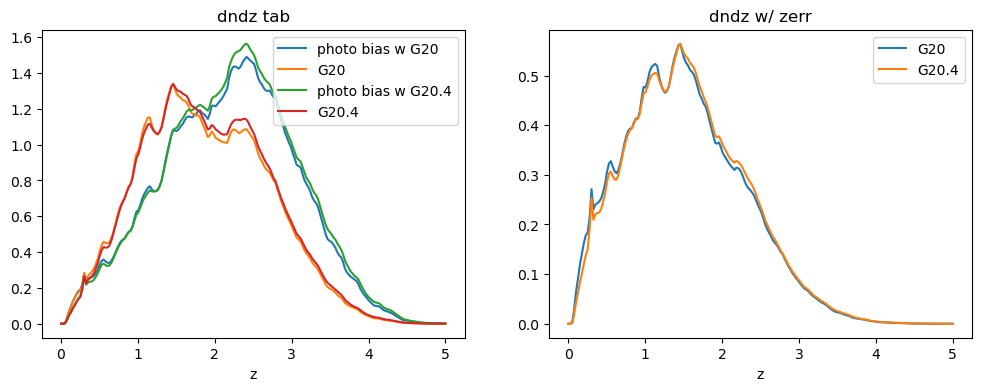

In [12]:
zint = np.linspace(0,5,200)

pl.figure(figsize=(12,4))
pl.subplot(121)
pl.title("dndz tab")
pl.plot(zint,b_g(zint,bz_model=bz_sdss_photo)*np.interp(zint,dndz_err[0],dndz_err[1]),label='photo bias w G20')
pl.plot(zint,b_g(zint)*np.interp(zint,dndz_err[0],dndz_err[1]),label='G20')
pl.plot(zint,b_g(zint,bz_model=bz_sdss_photo)*np.interp(zint,dndz_err[0],dndz_err[2]),label='photo bias w G20.4')
pl.plot(zint,b_g(zint)*np.interp(zint,dndz_err[0],dndz_err[2]),label='G20.4')
pl.legend()
pl.xlabel('z')
#pl.yscale('log')
pl.subplot(122)
pl.title("dndz w/ zerr")
pl.plot(zint,np.interp(zint,dndz_err[0],dndz_err[1]),label='G20')
pl.plot(zint,np.interp(zint,dndz_err[0],dndz_err[2]),label='G20.4')
pl.xlabel('z')
pl.legend()
pl.show()


In [19]:
def get_theory_cl(bias_func,dndz,fNL_th=0.,bz_model=bz_sdss,bg_model_rescaling=1,do_magnification=0.,lmax_th = binning.lmax):
    pars_nolimber = init_pars(lmin_limber=100,do_magnification_bias=do_magnification,do_cmb=False,do_transfer=False) 
    
    
    zs_p = dndz[0]#zs[zs<=dndz[0][-1]]
    ks = np.logspace(-6, 3, len(zs_p))
    bias_kz = np.ones((len(ks), len(zs_p)))
    
    for _i,z_i in enumerate(zs_p):
        bias_kz[:,_i] = bias_func(z_i,ks,fNL=fNL_th,z_pivot=0,bz_model=bz_model,bg_model_rescaling=bg_model_rescaling)
        
    W = dndz[1]
    pars_nolimber.SourceWindows = [SplinedSourceWindow(k_bias=ks, bias_kz=bias_kz, z=zs_p, W=W,source_type='counts',dlog10Ndm = do_magnification)]

    results_nolimber = camb.get_results(pars_nolimber)
    cls_nolimber = results_nolimber.get_source_cls_dict(raw_cl=True)        

    l_camb = np.arange(len(cls_nolimber["W1xW1"]))
    p2k= l_camb*(l_camb+1)/2    
    
    cl_gg_th = cls_nolimber['W1xW1']
    cl_kg_th = cls_nolimber['W1xP']*p2k
    #cl_kk_th = cls_nolimber['PxP']*p2k**2
    
    return l_camb[:lmax_th+1],cl_kg_th[:lmax_th+1], cl_gg_th[:lmax_th+1]



In [512]:
print(lbmask)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


In [21]:
#def func(x, a, b, c):
#    return a * np.exp(-b * x) + c
def get_fnl_stats(lbmask,datavec,datavec_err,cov,mydndz,do_magnification=0.,fit_type='all',sample=True):
    
    #cov = np.outer(datavec_err,datavec_err)
    ndim = cov.shape[0]
    assert ndim == int(np.sum(lbmask))
    assert ndim == len(datavec)
    #print(ndim,len(datavec),np.sum(lbmask))
    def func_bz_sdss(x, fNL):
        cls_th = get_theory_cl(b_h,[zint,np.interp(zint,mydndz[0],mydndz[1])],fNL_th=fNL,bz_model=bz_sdss,do_magnification=do_magnification)
        if fit_type=='all':
            return np.append(binning.bin_cell(cls_th[1]),binning.bin_cell(cls_th[2]))[lbmask]
        elif fit_type=='cross':
            return binning.bin_cell(cls_th[1])[lbmask]
        elif fit_type=='auto':
            return binning.bin_cell(cls_th[2])[lbmask]    
        else:
            raise ValueError("unknown fit type")
    def func_bz_sdss_photo(x, fNL):
        cls_th = get_theory_cl(b_h,[zint,np.interp(zint,mydndz[0],mydndz[1])],fNL_th=fNL,bz_model=bz_sdss_photo,do_magnification=do_magnification)
        if fit_type=='all':
            return np.append(binning.bin_cell(cls_th[1]),binning.bin_cell(cls_th[2]))[lbmask]
        elif fit_type=='cross':
            return binning.bin_cell(cls_th[1])[lbmask]
        elif fit_type=='auto':
            return binning.bin_cell(cls_th[2])[lbmask]    
        else:
            raise ValueError("unknown fit type") 
    
    
    popt, pcov = optimize.curve_fit(func_bz_sdss, lb, datavec,sigma=cov,p0=[0.],absolute_sigma=True)
    popt_photo, pcov_photo = optimize.curve_fit(func_bz_sdss_photo, lb, datavec,sigma=cov,p0=[0.],absolute_sigma=True)

    res = (datavec -func_bz_sdss(lb,popt[0]))
    res_photo = datavec -func_bz_sdss_photo(lb,popt_photo[0])
    chi2 = res@np.linalg.inv(cov)@res
    chi2_photo = res_photo@np.linalg.inv(cov)@res_photo    

    print(fsky,'sdss magmagbias',do_magnification,popt, np.sqrt(pcov),chi2/(ndim-pcov.shape[0]),1-stats.chi2.cdf(chi2,ndim-1))
    print(fsky,'sdss_photo magbias',do_magnification,popt_photo, np.sqrt(pcov_photo),chi2_photo/(ndim-pcov.shape[0]),1-stats.chi2.cdf(chi2_photo,ndim-1))    
    if sample:
        fnl_post =[]
        fnl_post_photo =[]    
        fnl_gridsearch = np.linspace(-300,300,75)
        for fnl_grid in fnl_gridsearch:
            res_grid = datavec -func_bz_sdss(lb,fnl_grid)
            fnl_post.append(res_grid@np.linalg.inv(cov)@res_grid)        
            
            res_photo_grid = datavec -func_bz_sdss_photo(lb,fnl_grid)
            fnl_post_photo.append(res_photo_grid@np.linalg.inv(cov)@res_photo_grid)
        
        pdf = np.exp(-0.5*np.array(fnl_post))
        pdf = pdf/np.trapz(pdf,fnl_gridsearch)
        pdf = pdf *np.diff(fnl_gridsearch)[0]
        cumpdf = np.cumsum(pdf)    
        lower_fnl = fnl_gridsearch[np.where(cumpdf>=0.16)[0]][0]
        upper_fnl = fnl_gridsearch[np.where(cumpdf>=0.84)[0]][0]
        lower_fnl_95 = fnl_gridsearch[np.where(cumpdf>=0.025)[0]][0]
        upper_fnl_95 = fnl_gridsearch[np.where(cumpdf>=0.975)[0]][0]
    
        
        pdf_photo = np.exp(-0.5*np.array(fnl_post_photo))
        pdf_photo = pdf_photo/np.trapz(pdf_photo,fnl_gridsearch)
        pdf_photo = pdf_photo *np.diff(fnl_gridsearch)[0]
        cumpdf_photo = np.cumsum(pdf_photo)    
        lower_fnl_photo = fnl_gridsearch[np.where(cumpdf_photo>=0.16)[0]][0]
        upper_fnl_photo = fnl_gridsearch[np.where(cumpdf_photo>=0.84)[0]][0]
        lower_fnl_photo_95 = fnl_gridsearch[np.where(cumpdf_photo>=0.025)[0]][0]
        upper_fnl_photo_95 = fnl_gridsearch[np.where(cumpdf_photo>=0.975)[0]][0]    
        
        results={}
        results['sdss']= {'bestfit':[popt, np.sqrt(pcov)],'chi2': chi2/(ndim-pcov.shape[0]), 
                          'PTE':1-stats.chi2.cdf(chi2,ndim-1),'sigma':[lower_fnl,upper_fnl],
                          '2sigma':[lower_fnl_95,upper_fnl_95],
                           'posterior':[fnl_gridsearch,pdf]}
        results['sdss_photo']= {'bestfit':[popt_photo, np.sqrt(pcov_photo)],'chi2': chi2_photo/(ndim-pcov.shape[0]), 
                          'PTE':1-stats.chi2.cdf(chi2_photo,ndim-1),'sigma':[lower_fnl_photo,upper_fnl_photo],
                          '2sigma':[lower_fnl_photo_95,upper_fnl_photo_95],
                           'posterior':[fnl_gridsearch,pdf_photo]}
        return results
    else:
        return 

In [382]:
results_baseline ={}
for fsky in kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data(kyoto,'G20',fsky)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.)
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.37)
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.5)
    results_baseline[fsky]={'baseline':results_nomag,'magbias_dNcum':results_0p52,'magbias_dN':results_0p37}
    print()
with open("kyoto_fnl_posterior.pkl","wb") as f:
    pkl.dump(results_baseline,f)
    

70 sdss magmagbias 0.0 [-42.69785534] [[48.11545013]] 1.2503003180712566 0.1500920006903912
70 sdss_photo magbias 0.0 [3.14687503] [[37.70444645]] 1.2582961242778543 0.1435786454273128
70 sdss magmagbias 0.37 [-28.76714377] [[47.95940667]] 1.2244410660422584 0.17269591215457514
70 sdss_photo magbias 0.37 [15.34381363] [[37.29757144]] 1.2222858205191136 0.17468794877161276
70 sdss magmagbias 0.5 [-89.94311754] [[48.4455049]] 1.3441905378930692 0.08665335412054143
70 sdss_photo magbias 0.5 [-41.73466698] [[38.79869013]] 1.379419874839413 0.06943605175963496

60 sdss magmagbias 0.0 [-48.29849571] [[48.49211914]] 1.2683285048928212 0.13571613806162874
60 sdss_photo magbias 0.0 [-4.86617942] [[38.21551199]] 1.275198728055285 0.13052748267749914
60 sdss magmagbias 0.37 [-35.31555382] [[48.35300623]] 1.2422681189208988 0.15685912508426614
60 sdss_photo magbias 0.37 [6.48904312] [[37.85661717]] 1.2400320698037717 0.15878338635148015
60 sdss magmagbias 0.5 [-92.23676571] [[48.79198439]] 1.36367

In [544]:
print("high ell gg")    
results_baseline_highellgg ={}
for fsky in kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data(kyoto,'G20',fsky,lmin_gg=40)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.)
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.37)
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.5)
    results_baseline_highellgg[fsky]={'baseline':results_nomag,'magbias_dNcum':results_0p52,'magbias_dN':results_0p37}
    print()
with open("kyoto_fnl_posterior_highellgg.pkl","wb") as f:
    pkl.dump(results_baseline_highellgg,f)  
    

high ell gg
lb 36 post cut data 34
70 sdss magmagbias 0.0 [-56.39444783] [[48.36590556]] 0.9945209007098381 0.47611065477830794
70 sdss_photo magbias 0.0 [-23.08168696] [[38.80984236]] 1.0005545409156738 0.46635901677192493
70 sdss magmagbias 0.37 [-45.87075402] [[48.3376925]] 0.9694077275118104 0.5172168712879328
70 sdss_photo magbias 0.37 [-14.54283262] [[38.75054692]] 0.9718625490429387 0.513168599503055
70 sdss magmagbias 0.5 [-91.72473963] [[48.45510586]] 1.095000682135268 0.3242452764203846
70 sdss_photo magbias 0.5 [-51.96127045] [[38.99709684]] 1.1103413053402804 0.30356961536520277

lb 36 post cut data 34
60 sdss magmagbias 0.0 [-59.29540341] [[48.71458755]] 1.1019592974885326 0.31477069377118005
60 sdss_photo magbias 0.0 [-25.37015119] [[39.13678473]] 1.1048367170435676 0.31089923556521426
60 sdss magmagbias 0.37 [-48.98727502] [[48.68699504]] 1.0759943922831234 0.3509068794654798
60 sdss_photo magbias 0.37 [-16.9669149] [[39.07811329]] 1.0747081458059173 0.35275128627379004


In [519]:
print("cross only") 
results_baseline_kg ={}
for fsky in [50]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data_kg(kyoto,'G20',fsky)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.,fit_type='cross')
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.37,fit_type='cross')
    results_0p52 = get_fnl_stats(lbmaskdatavec,datavec_err,cov,dndz_err,do_magnification=0.5,fit_type='cross')
    results_baseline_kg[fsky]={'baseline':results_nomag,'magbias_dNcum':results_0p52,'magbias_dN':results_0p37}
    print()
with open("kyoto_fnl_posterior_kg.pkl","wb") as f:
    pkl.dump(results_baseline_kg,f)


cross only
50 sdss magmagbias 0.0 [-52.00352742] [[51.65561646]] 1.5237909575409443 0.07621910115587571
50 sdss_photo magbias 0.0 [-21.65209063] [[42.17857292]] 1.6418269058557726 0.045988260042386764
50 sdss magmagbias 0.37 [-42.45306508] [[51.65564661]] 1.4665426632667313 0.09625962141629696
50 sdss_photo magbias 0.37 [-13.63254195] [[42.17860166]] 1.5846945283362788 0.05895650969967714
50 sdss magmagbias 0.5 [-83.83803261] [[51.65560345]] 1.7415372199611372 0.029329455700065288
50 sdss_photo magbias 0.5 [-48.38366464] [[42.17859599]] 1.8575131976283303 0.016971266417224573



In [545]:
print("auto only") 
results_baseline_gg ={}
for fsky in [50]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data_gg(kyoto,'G20',fsky)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.,fit_type='auto')
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.37,fit_type='auto')
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.5,fit_type='auto')
    results_baseline_gg[fsky]={'baseline':results_nomag,'magbias_dNcum':results_0p52,'magbias_dN':results_0p37}
    print()
with open("kyoto_fnl_posterior_gg.pkl","wb") as f:
    pkl.dump(results_baseline_gg,f)

  
    

auto only
50 sdss magmagbias 0.0 [120.31945287] [[76.5179898]] 0.781449714871839 0.708675726069725
50 sdss_photo magbias 0.0 [99.18587882] [[49.45094917]] 0.7280197982111918 0.7678137287460662
50 sdss magmagbias 0.37 [129.14359013] [[75.07636559]] 0.781773761487123 0.7083056959973569
50 sdss_photo magbias 0.37 [103.67289627] [[48.715868]] 0.7260992372123309 0.7698584919136111
50 sdss magmagbias 0.5 [86.01796476] [[82.8007383]] 0.7886321580311049 0.7004478774658411
50 sdss_photo magbias 0.5 [81.81152646] [[52.53694757]] 0.7403786204829612 0.7545071892746974



In [540]:
print("auto only high ell gg")    
results_baseline_gg_highellgg ={}
for fsky in [50]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data_gg(kyoto,'G20',fsky,lmin_gg=40)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.,fit_type='auto')
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.37,fit_type='auto')
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.5,fit_type='auto')
    results_baseline_gg_highellgg[fsky]={'baseline':results_nomag,'magbias_dNcum':results_0p52,'magbias_dN':results_0p37}
    print()
with open("kyoto_fnl_posterior_gg_highellgg.pkl","wb") as f:

    pkl.dump(results_baseline_gg_highellgg,f)

auto only high ell gg
50 sdss magmagbias 0.0 [-46.49765338] [[168.64104304]] 0.7060597350499971 0.7810194187492902
50 sdss_photo magbias 0.0 [-9.69856936] [[108.68141758]] 0.650978145957035 0.8342757291561642
50 sdss magmagbias 0.37 [-28.05759363] [[164.80755656]] 0.7182151500253191 0.768497989965947
50 sdss_photo magbias 0.37 [0.1045947] [[106.58693569]] 0.6584795921523994 0.8273927983960205
50 sdss magmagbias 0.5 [-116.57965001] [[185.05965295]] 0.6682387510194631 0.8182539749091715
50 sdss_photo magbias 0.5 [-47.30812738] [[117.51593605]] 0.6271666824894678 0.855265416599793



In [877]:
print("alt Cls pol")    
results_baseline_dr3pol ={}
for fsky in [50]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data(kyoto,'G20',fsky,alternative_cl='cls_kpol')
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.)
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.37)
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.5)
    results_baseline_dr3pol[fsky]={'baseline':results_nomag,'magbias_dNcum':results_0p52,'magbias_dN':results_0p37}
    print()
with open("kyoto_fnl_posterior_dr3pol.pkl","wb") as f:

    pkl.dump(results_baseline_dr3pol,f)

alt Cls pol
alt cl cls_kpol
lb 36 post cut data 35
50 sdss magmagbias 0.0 [37.19795752] [[75.23949944]] 0.8557765037032758 0.7067602639136126
50 sdss_photo magbias 0.0 [66.68573784] [[49.66785201]] 0.8086435162525798 0.7774121210360133
50 sdss magmagbias 0.37 [51.12531949] [[73.72759637]] 0.8584216647798172 0.7025916618562247
50 sdss_photo magbias 0.37 [73.7300458] [[48.69576987]] 0.806913104862261 0.7798555699873126
50 sdss magmagbias 0.5 [-19.37269464] [[81.34367583]] 0.8473991049876884 0.7198367241734078
50 sdss_photo magbias 0.5 [37.58216911] [[53.93043968]] 0.8165042864574574 0.7661653997291835



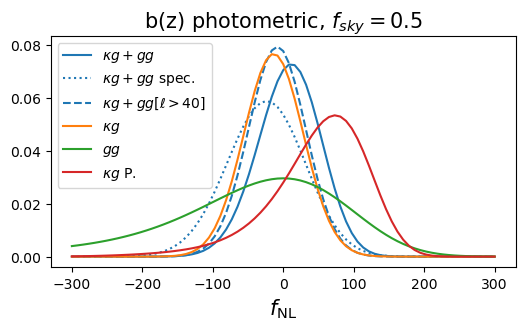

In [882]:
pl.figure(figsize=(6,3))
pl.plot(test_s_g204_dndz204_highell['sdss']['posterior'][0],results_baseline[50]['magbias_dN']['sdss_photo']['posterior'][1],label='$\kappa g + gg$')    
pl.plot(test_s_g204_dndz204_highell['sdss']['posterior'][0],results_baseline[50]['magbias_dN']['sdss']['posterior'][1],label='$\kappa g + gg$ spec.',color='C0',ls=':')    
pl.plot(test_s_g204_dndz204_highell['sdss_photo']['posterior'][0],results_baseline_highellgg[50]['magbias_dN']['sdss_photo']['posterior'][1],label='$\kappa g + gg[\ell>40]$',color='C0',ls='--')    
pl.plot(test_s_g204_dndz204_highell['sdss_photo']['posterior'][0],results_baseline_kg[50]['magbias_dN']['sdss_photo']['posterior'][1],label='$\kappa g$',color='C1')    
#pl.plot(test_s_g204_dndz204['sdss']['posterior'][0],test_s_g204_dndz204['sdss']['posterior'][1],label="$f_{sky}=%.1f$"%(float(50)/100),color='C0',ls='--')    
#pl.plot(test_s_g204_dndz204['sdss_photo']['posterior'][0],results_baseline_gg[50]['magbias_dN']['sdss_photo']['posterior'][1],label="$f_{sky}=%.1f$"%(float(50)/100),color='C1',ls='--')    
pl.plot(test_s_g204_dndz204['sdss_photo']['posterior'][0],results_baseline_gg_highellgg[50]['magbias_dN']['sdss_photo']['posterior'][1],label='$gg$',color='C2') 
pl.plot(test_s_g204_dndz204_highell['sdss']['posterior'][0],results_baseline_dr3pol[50]['magbias_dN']['sdss_photo']['posterior'][1],label='$\kappa g$ P.',color='C3')    
pl.xlabel("$f_{\\rm NL}$",size=15)
pl.title("b(z) photometric, $f_{sky}=0.5$",size=15)
pl.legend()

# G20.4

In [543]:
results_baseline204 ={}
for fsky in [50]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data(kyoto,'G20.4',fsky)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.)
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.34)
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.22)
    results_baseline204[fsky]={'baseline':results_nomag,'magbias_dNcum':results_0p52,'magbias_dN':results_0p37}
    print()
with open("kyoto_fnl_posterior_204.pkl","wb") as f:
    pkl.dump(results_baseline204,f)

lb 36 post cut data 35
50 sdss magmagbias 0.0 [-67.80281043] [[42.54952777]] 1.724176078567945 0.005434906557188035
50 sdss_photo magbias 0.0 [-18.10320984] [[32.84477011]] 1.7817220149451705 0.0033518801669960574
50 sdss magmagbias 0.34 [-40.23559847] [[42.06329534]] 1.6628654394686346 0.00894575518567653
50 sdss_photo magbias 0.34 [4.32149849] [[31.85404499]] 1.6880110593706517 0.0073077025067883605
50 sdss magmagbias 0.22 [11.13618902] [[40.83231502]] 1.5564221577741595 0.020339676908975535
50 sdss_photo magbias 0.22 [41.29950818] [[29.96563817]] 1.5132451743729871 0.027904289065091126



In [546]:
# test G204
datavec,datavec_err,cov,lbmask = prepare_data(kyoto,'G20.4',50)
test_s_g204 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err,do_magnification=0.146)


lb 36 post cut data 35
50 sdss magmagbias 0.146 [39.80325689] [[40.00250977]] 1.5022247318763045 0.03019974448419327
50 sdss_photo magbias 0.146 [59.81964666] [[28.96380388]] 1.4193942416948524 0.053487305805973495


In [548]:
# test G204
datavec,datavec_err,cov,lbmask = prepare_data(kyoto,'G20.4',50)
test_s_g204_dndz204 = get_fnl_stats(lbmask,datavec,datavec_err,cov,[dndz_err[0],dndz_err[2]],do_magnification=0.146)

datavec,datavec_err,cov,lbmask = prepare_data(kyoto,'G20.4',50,lmin_gg=40)
test_s_g204_dndz204_highell = get_fnl_stats(lbmask,datavec,datavec_err,cov,[dndz_err[0],dndz_err[2]],do_magnification=0.146)

lb 36 post cut data 35
50 sdss magmagbias 0.146 [44.69802687] [[38.46798862]] 1.465838050590759 0.039013938848495355
50 sdss_photo magbias 0.146 [53.41965937] [[27.61830624]] 1.4020019375517503 0.0599923897935325
lb 36 post cut data 34
50 sdss magmagbias 0.146 [20.09699059] [[41.17474572]] 1.424854325741348 0.053920396433225326
50 sdss_photo magbias 0.146 [32.14500072] [[31.74341823]] 1.387929884980093 0.06833559069454642


G20.4
50 (-32.4) 24.3 < 53.4 < 81.1 (105.4)
50 (-64.9) 0.0 < 44.7 < 81.1 (121.6)
G20.4 high_ell
50 (-32.4) 0.0 < 32.1 < 64.9 (97.3)
50 (-64.9) -24.3 < 20.1 < 64.9 (97.3)


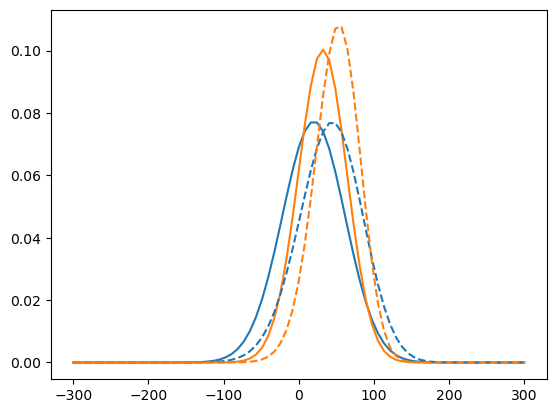

In [575]:
print("G20.4")
print(fsky, '(%.1f) %.1f < %.1f < %.1f (%.1f)'%(
    test_s_g204_dndz204_highell['sdss_photo']['2sigma'][0],
        test_s_g204_dndz204['sdss_photo']['sigma'][0],
        test_s_g204_dndz204['sdss_photo']['bestfit'][0],
        test_s_g204_dndz204['sdss_photo']['sigma'][1],
        test_s_g204_dndz204['sdss_photo']['2sigma'][1]) )


print(fsky, '(%.1f) %.1f < %.1f < %.1f (%.1f)'%(
    test_s_g204_dndz204_highell['sdss']['2sigma'][0],
        test_s_g204_dndz204['sdss']['sigma'][0],
        test_s_g204_dndz204['sdss']['bestfit'][0],
        test_s_g204_dndz204['sdss']['sigma'][1],
        test_s_g204_dndz204['sdss']['2sigma'][1]) )

print("G20.4 high_ell")
print(fsky, '(%.1f) %.1f < %.1f < %.1f (%.1f)'%(
    test_s_g204_dndz204_highell['sdss_photo']['2sigma'][0],
        test_s_g204_dndz204_highell['sdss_photo']['sigma'][0],
        test_s_g204_dndz204_highell['sdss_photo']['bestfit'][0],
        test_s_g204_dndz204_highell['sdss_photo']['sigma'][1],
        test_s_g204_dndz204_highell['sdss_photo']['2sigma'][1]) )


print(fsky, '(%.1f) %.1f < %.1f < %.1f (%.1f)'%(
    test_s_g204_dndz204_highell['sdss']['2sigma'][0],
        test_s_g204_dndz204_highell['sdss']['sigma'][0],
        test_s_g204_dndz204_highell['sdss']['bestfit'][0],
        test_s_g204_dndz204_highell['sdss']['sigma'][1],
        test_s_g204_dndz204_highell['sdss']['2sigma'][1]) )

pl.plot(test_s_g204_dndz204_highell['sdss']['posterior'][0],test_s_g204_dndz204_highell['sdss']['posterior'][1],label="$f_{sky}=%.1f$"%(float(50)/100))    
pl.plot(test_s_g204_dndz204_highell['sdss_photo']['posterior'][0],test_s_g204_dndz204_highell['sdss_photo']['posterior'][1],label="$f_{sky}=%.1f$"%(float(50)/100))    
pl.plot(test_s_g204_dndz204['sdss']['posterior'][0],test_s_g204_dndz204['sdss']['posterior'][1],label="$f_{sky}=%.1f$"%(float(50)/100),color='C0',ls='--')    
pl.plot(test_s_g204_dndz204['sdss_photo']['posterior'][0],test_s_g204_dndz204['sdss_photo']['posterior'][1],label="$f_{sky}=%.1f$"%(float(50)/100),color='C1',ls='--')    
#pl.plot(results_baseline[50]['magbias_dNcum']['sdss']['posterior'][0],results_baseline[50]['magbias_dNcum']['sdss']['posterior'][1],label="$f_{sky}=%.1f$"%(float(50)/100),color='C0',ls='--')
#pl.plot(results_baseline[50]['magbias_dNcum']['sdss_photo']['posterior'][0],results_baseline[50]['magbias_dNcum']['sdss_photo']['posterior'][1],label="$f_{sky}=%.1f$"%(float(50)/100),color='C1',ls='--')
#pl.plot(results_baseline[50]['magbias_dNcum']['sdss']['posterior'][0],results_baseline[50]['magbias_dN']['sdss']['posterior'][1],label="$f_{sky}=%.1f$"%(float(50)/100),color='C0',ls=':')
#pl.plot(results_baseline[50]['magbias_dN']['sdss_photo']['posterior'][0],results_baseline[50]['magbias_dN']['sdss_photo']['posterior'][1],label="$f_{sky}=%.1f$"%(float(50)/100),color='C1',ls=':')
pl.show()

In [625]:
th204 = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=test_s_g204_dndz204_highell['sdss']['bestfit'][0],bz_model=bz_sdss)
th_photo204 = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=test_s_g204_dndz204_highell['sdss_photo']['bestfit'][0],bz_model=bz_sdss_photo)    
th_magdN204 = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=test_s_g204_dndz204_highell['sdss']['bestfit'][0],bz_model=bz_sdss,do_magnification=0.146)
th_photo_magdN204 = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=test_s_g204_dndz204_highell['sdss_photo']['bestfit'][0],bz_model=bz_sdss_photo,do_magnification=0.146)    
th_magdNcum204 = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=test_s_g204_dndz204_highell['sdss']['bestfit'][0],bz_model=bz_sdss,do_magnification=0.146)
th_photo_magdNcum204 = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=test_s_g204_dndz204_highell['sdss_photo']['bestfit'][0],bz_model=bz_sdss_photo,do_magnification=0.146)    

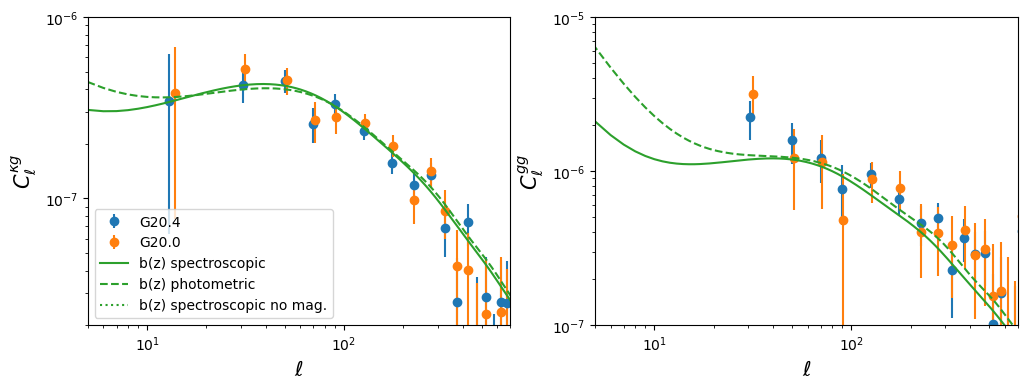

In [628]:


for fsky in [50]:#kyoto.keys():
    pl.figure(figsize=(12,4))
    pl.subplot(121)
    pl.errorbar(lb,kyoto[fsky]['G20.4']['clkg'][0],kyoto[fsky]['G20.4']['clkg'][1],marker='o',ls='',label='G20.4')
    pl.errorbar(lb+1,kyoto[fsky]['G20']['clkg'][0],kyoto[fsky]['G20']['clkg'][1],marker='o',ls='',label='G20.0')
    #pl.errorbar(lb+1,kyoto['G20.4']['clkg'][0],kyoto[fsky]['G20.4']['clkg'][1],marker='o',ls='',label='G20.4')
    #pl.errorbar(th[0],th204[1],color='C0')
    #pl.errorbar(th[0],th_photo204[1],color='C0')
    #pl.errorbar(th[0],th_magdN204[1],color='C1')
    #pl.errorbar(th[0],th_photo_magdN204[1],color='C1',ls='--')    
    pl.errorbar(th[0],th_magdNcum204[1],color='C2',label='b(z) spectroscopic')
    pl.errorbar(th[0],th_photo_magdNcum204[1],color='C2',ls='--',label='b(z) photometric')        
    pl.errorbar(th[0],th204[1],color='C2',ls=':',label='b(z) spectroscopic no mag.')    
    pl.xscale('log')
    pl.yscale('log')
    pl.ylim(2e-08,1e-06)
    pl.xlim(5,700)
    pl.legend()
    pl.xlabel("$\ell$",size=15)
    pl.ylabel("$C^{\kappa g}_\ell$",size=15)    
    
    pl.subplot(122)
    pl.errorbar(lb,kyoto[fsky]['G20.4']['clgg'][0],kyoto[fsky]['G20.4']['clgg'][1],marker='o',ls='',label='G20.4')
    pl.errorbar(lb+1,kyoto[fsky]['G20']['clgg'][0],kyoto[fsky]['G20']['clgg'][1],marker='o',ls='',label='G20.0')
    #pl.errorbar(lb+3,kyoto[fsky]['G20.4']['clgg'][0],kyoto[fsky]['G20.4']['clgg'][1],marker='o',ls='')
    #pl.errorbar(th[0],th204[2],color='C0')
    #pl.errorbar(th[0],th_photo204[2],color='C0')
    #pl.errorbar(th[0],th_magdN204[2],color='C1')
    #pl.errorbar(th[0],th_photo_magdN204[2],color='C1',ls='--')    
    pl.errorbar(th[0],th_magdNcum204[2],color='C2',label='b(z) spectroscopic')
    pl.errorbar(th[0],th_photo_magdNcum204[2],color='C2',ls='--',label='b(z) photometric')  
    pl.errorbar(th[0],th204[2]*2,color='C2',ls=':',label='b(z) spectroscopic no mag.')        
    pl.xscale('log')
    pl.yscale('log')
    pl.xlabel("$\ell$",size=15)
    pl.ylabel("$C^{gg}_\ell$",size=15)
    pl.ylim(1e-07,1e-05)
    pl.xlim(5,700)
    

In [619]:
th20 = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=results_baseline[50]['baseline']['sdss']['bestfit'][0],bz_model=bz_sdss,do_magnification=0.37)
th20_photo = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=results_baseline[50]['baseline']['sdss_photo']['bestfit'][0],bz_model=bz_sdss_photo,do_magnification=0.37)    

th20_nomag = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=results_baseline[50]['baseline']['sdss']['bestfit'][0],bz_model=bz_sdss)
th20_photo_nomag = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=results_baseline[50]['baseline']['sdss_photo']['bestfit'][0],bz_model=bz_sdss_photo)    

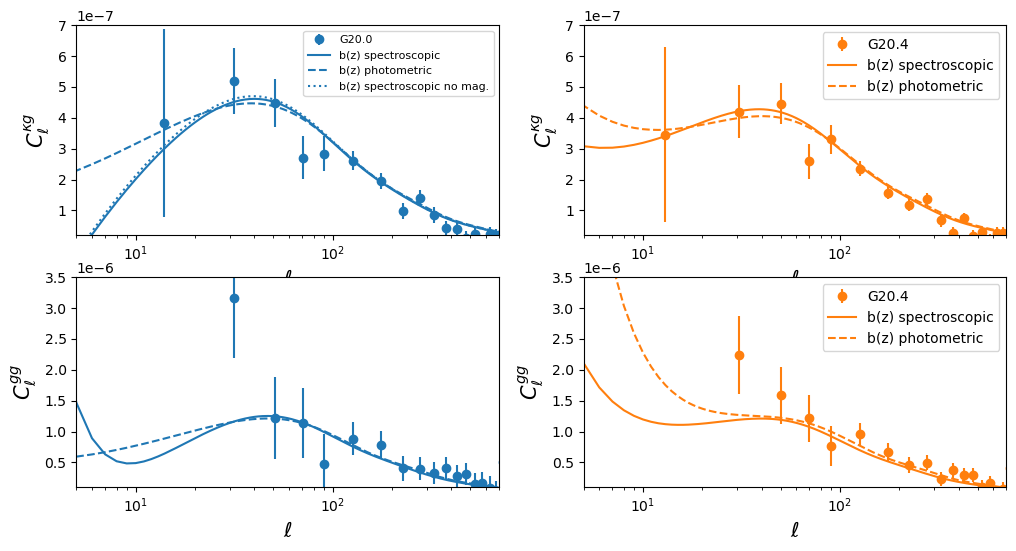

In [635]:


for fsky in [50]:#kyoto.keys():
    pl.figure(figsize=(12,6))
    pl.subplot(221)
    #pl.errorbar(lb,kyoto[fsky]['G20.4']['clkg'][0],kyoto[fsky]['G20.4']['clkg'][1],marker='o',ls='',label='G20.4')
    pl.errorbar(lb+1,kyoto[fsky]['G20']['clkg'][0],kyoto[fsky]['G20']['clkg'][1],marker='o',ls='',label='G20.0')
    #pl.errorbar(lb+1,kyoto['G20.4']['clkg'][0],kyoto[fsky]['G20.4']['clkg'][1],marker='o',ls='',label='G20.4')
    #pl.errorbar(th[0],th204[1],color='C0')   
    pl.errorbar(th[0],th20[1],color='C0',label='b(z) spectroscopic')
    pl.errorbar(th[0],th20_photo[1],color='C0',ls='--',label='b(z) photometric')        
    pl.errorbar(th[0],th20_nomag[1],color='C0',label='b(z) spectroscopic no mag.',ls=':')        
    #pl.errorbar(th[0],th_magdNcum204[1],color='C0',label='b(z) spectroscopic')
    #pl.errorbar(th[0],th_photo_magdNcum204[1],color='C0',ls='--',label='b(z) photometric')        
    pl.xscale('log')
    #pl.yscale('log')
    pl.ylim(2e-08,0.7e-06)
    pl.xlim(5,700)
    pl.legend(loc='upper right',fontsize=8)
    pl.xlabel("$\ell$",size=15)
    pl.ylabel("$C^{\kappa g}_\ell$",size=15)    
    
    pl.subplot(223)
    #pl.errorbar(lb,kyoto[fsky]['G20.4']['clgg'][0],kyoto[fsky]['G20.4']['clgg'][1],marker='o',ls='',label='G20.4')
    pl.errorbar(lb+1,kyoto[fsky]['G20']['clgg'][0],kyoto[fsky]['G20']['clgg'][1],marker='o',ls='',label='G20.0') 
    pl.errorbar(th[0],th20[2],color='C0',label='b(z) spectroscopic')
    pl.errorbar(th[0],th20_photo[2],color='C0',ls='--',label='b(z) photometric')     
    #pl.errorbar(th[0],th_magdNcum204[2],color='C2',label='b(z) spectroscopic')
    #pl.errorbar(th[0],th_photo_magdNcum204[2],color='C2',ls='--',label='b(z) photometric')        
    pl.xscale('log')
    #pl.yscale('log')
    pl.xlabel("$\ell$",size=15)
    pl.ylabel("$C^{gg}_\ell$",size=15)
    pl.ylim(1e-07,3.5e-06)
    pl.xlim(5,700)
    
    
    pl.subplot(222)
    pl.errorbar(lb,kyoto[fsky]['G20.4']['clkg'][0],kyoto[fsky]['G20.4']['clkg'][1],marker='o',ls='',label='G20.4',color='C1')
    #pl.errorbar(lb+1,kyoto[fsky]['G20']['clkg'][0],kyoto[fsky]['G20']['clkg'][1],marker='o',ls='',label='G20.0')
    #pl.errorbar(lb+1,kyoto['G20.4']['clkg'][0],kyoto[fsky]['G20.4']['clkg'][1],marker='o',ls='',label='G20.4')
    #pl.errorbar(th[0],th204[1],color='C0')   
    #pl.errorbar(th[0],th20[1],color='C1',label='b(z) spectroscopic')
    #pl.errorbar(th[0],th20_photo[1],color='C1',ls='--',label='b(z) photometric')        
    pl.errorbar(th[0],th_magdNcum204[1],color='C1',label='b(z) spectroscopic')
    pl.errorbar(th[0],th_photo_magdNcum204[1],color='C1',ls='--',label='b(z) photometric')        
    pl.xscale('log')
    #pl.yscale('log')
    pl.ylim(2e-08,0.7e-06)
    pl.xlim(5,700)
    pl.legend()
    pl.xlabel("$\ell$",size=15)
    pl.ylabel("$C^{\kappa g}_\ell$",size=15)    
    
    pl.subplot(224)
    pl.errorbar(lb,kyoto[fsky]['G20.4']['clgg'][0],kyoto[fsky]['G20.4']['clgg'][1],marker='o',ls='',label='G20.4',color='C1')
    #pl.errorbar(lb+1,kyoto[fsky]['G20']['clgg'][0],kyoto[fsky]['G20']['clgg'][1],marker='o',ls='',label='G20.0') 
    #pl.errorbar(th[0],th20[2],color='C1',label='b(z) spectroscopic')
    #pl.errorbar(th[0],th20_photo[2],color='C1',ls='--',label='b(z) photometric')     
    pl.errorbar(th[0],th_magdNcum204[2],color='C1',label='b(z) spectroscopic')
    pl.errorbar(th[0],th_photo_magdNcum204[2],color='C1',ls='--',label='b(z) photometric')        
    pl.xscale('log')
    #pl.yscale('log')
    pl.xlabel("$\ell$",size=15)
    pl.ylabel("$C^{gg}_\ell$",size=15)
    pl.ylim(1e-07,3.5e-06)
    pl.xlim(5,700)
    pl.legend()
    pl.show()
    

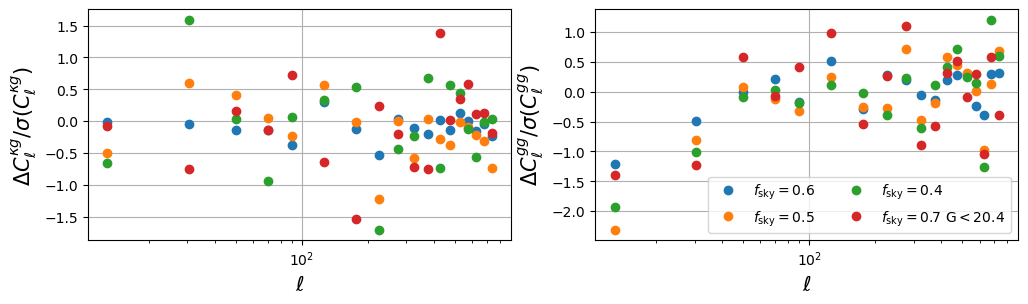

dict_keys(['clkg', 'clgXg', 'clgg', 'clgjk', 'clkgjk', 'clkk', 'cls_ktt', 'cls_kpol', 'cls_kmv', 'cls_nodust', 'cls_nocib', 'cls_pr3nosz'])


In [756]:
fsky_ref = 70
ref_kg = kyoto[fsky_ref]['G20']['clkg'][0]
ref_kg_err = kyoto[fsky_ref]['G20']['clkg'][1]

ref_gg = kyoto[fsky_ref]['G20']['clgg'][0]
ref_gg_err = kyoto[fsky_ref]['G20']['clgg'][1]

pl.figure(figsize=(12,3))
pl.subplot(121)
for i,fsky in enumerate([70,60,50,40]):
    if fsky==fsky_ref:continue
    pl.errorbar(lb+i*0,(kyoto[fsky]['G20']['clkg'][0]-ref_kg)/ref_kg_err,ls='',marker='o',label='$f_{\\rm sky}=%.1f$'%(fsky/100.))
pl.errorbar(lb+i*0,(kyoto[70]['G20.4']['clkg'][0]-ref_kg)/ref_kg_err,ls='',marker='o',label='$f_{\\rm sky}=%.1f$ G$<$20.4'%(70/100.))  
pl.grid()
#pl.legend()
pl.xscale('log')
pl.ylabel("$\Delta C_\ell^{\kappa g}/\sigma(C_\ell^{\kappa g})$",size=15)
pl.xlabel("$\ell$",size=15)

pl.subplot(122)
for i,fsky in enumerate([70,60,50,40]):
    if fsky==fsky_ref:continue
    pl.errorbar(lb+i*0,(kyoto[fsky]['G20']['clgg'][0]-ref_gg)/ref_gg_err,ls='',marker='o',label='$f_{\\rm sky}=%.1f$'%(fsky/100.))
pl.errorbar(lb+i*0,(kyoto[70]['G20.4']['clgg'][0]-ref_gg)/ref_gg_err,ls='',marker='o',label='$f_{\\rm sky}=%.1f$ G$<$20.4'%(70/100.))    
pl.grid()   
pl.ylabel("$\Delta C_\ell^{gg}/\sigma(C_\ell^{gg})$",size=15)
pl.xlabel("$\ell$",size=15)
pl.xscale('log')   
#pl.yscale('log')
pl.legend(ncol=2)    
pl.show()
print(kyoto[70]['G20'].keys())

Text(0.5, 0, '$\\ell$')

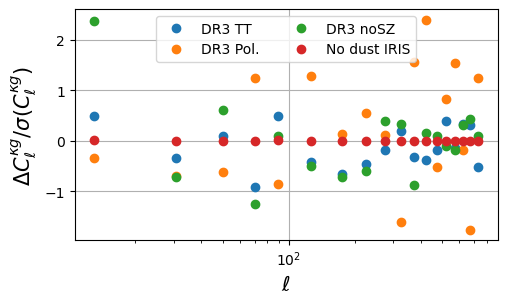

In [885]:
fsky_ref = 40
ref_kg = kyoto[fsky_ref]['G20']['clkg'][0]
ref_kg_err = kyoto[fsky_ref]['G20']['clkg'][1]

labels = ['DR3 TT','DR3 Pol.','DR3 noSZ','No dust IRIS']
fsky=fsky_ref
pl.figure(figsize=(12,3))
pl.subplot(121)
#pl.errorbar(lb+i*0,kyoto[fsky]['G20']['clkg'][0],kyoto[fsky]['G20']['clkg'][1],ls='',marker='o',color='black')
for i,cltype in enumerate(['cls_ktt','cls_kpol','cls_pr3nosz','cls_nodust']):#,60,50,40]):
    pl.errorbar(lb+i*0,(kyoto[fsky]['G20'][cltype][0][0][0]-ref_kg)/kyoto[fsky]['G20'][cltype][0][1][0],ls='',marker='o',label=labels[i])
pl.grid()
pl.legend(ncol=2)
pl.xscale('log')
pl.ylabel("$\Delta C_\ell^{\kappa g}/\sigma(C_\ell^{\kappa g})$",size=15)
pl.xlabel("$\ell$",size=15)


In [414]:
print("photo")
for fsky in kyoto.keys():
    print(fsky, '(%.1f) %.1f < %.1f < %.1f (%.1f)'%(
        results_baseline[fsky]['baseline']['sdss_photo']['2sigma'][0],
            results_baseline[fsky]['baseline']['sdss_photo']['sigma'][0],
            results_baseline[fsky]['baseline']['sdss_photo']['bestfit'][0],
            results_baseline[fsky]['baseline']['sdss_photo']['sigma'][1],
            results_baseline[fsky]['baseline']['sdss_photo']['2sigma'][1]) )                                                   
print("spec")
for fsky in kyoto.keys():
    print(fsky, '(%.1f) %.1f < %.1f < %.1f (%.1f)'%(
            results_baseline[fsky]['baseline']['sdss']['2sigma'][0],
            results_baseline[fsky]['baseline']['sdss']['sigma'][0],
            results_baseline[fsky]['baseline']['sdss']['bestfit'][0],
            results_baseline[fsky]['baseline']['sdss']['sigma'][1],
            results_baseline[fsky]['baseline']['sdss']['2sigma'][1]))                                                   

    
    

photo
70 (-97.3) -48.6 < 3.1 < 48.6 (89.2)
60 (-97.3) -56.8 < -4.9 < 40.5 (81.1)
50 (-89.2) -48.6 < 1.5 < 40.5 (81.1)
40 (-97.3) -48.6 < 3.4 < 48.6 (89.2)
20 (-113.5) -56.8 < 12.7 < 64.9 (121.6)
spec
70 (-154.1) -97.3 < -42.7 < 8.1 (64.9)
60 (-162.2) -105.4 < -48.3 < 8.1 (56.8)
50 (-145.9) -89.2 < -35.3 < 16.2 (73.0)
40 (-145.9) -89.2 < -30.5 < 24.3 (81.1)
20 (-170.3) -97.3 < -18.5 < 56.8 (121.6)


In [417]:
print("photo magdN")
for fsky in kyoto.keys():
    print(fsky, '(%.1f) %.1f < %.1f < %.1f (%.1f)'%(
        results_baseline[fsky]['baseline']['sdss_photo']['2sigma'][0],
            results_baseline[fsky]['magbias_dN']['sdss_photo']['sigma'][0],
            results_baseline[fsky]['magbias_dN']['sdss_photo']['bestfit'][0],
            results_baseline[fsky]['magbias_dN']['sdss_photo']['sigma'][1],
            results_baseline[fsky]['magbias_dN']['sdss_photo']['2sigma'][1]) )                                                   
print("spec magdN")
for fsky in kyoto.keys():
    print(fsky, '(%.1f) %.1f < %.1f < %.1f (%.1f)'%(
            results_baseline[fsky]['magbias_dN']['sdss']['2sigma'][0],
            results_baseline[fsky]['magbias_dN']['sdss']['sigma'][0],
            results_baseline[fsky]['magbias_dN']['sdss']['bestfit'][0],
            results_baseline[fsky]['magbias_dN']['sdss']['sigma'][1],
            results_baseline[fsky]['magbias_dN']['sdss']['2sigma'][1]))                                                   
print()
print("photo magdNcum")
for fsky in kyoto.keys():
    print(fsky, '(%.1f) %.1f < %.1f < %.1f (%.1f)'%(
        results_baseline[fsky]['baseline']['sdss_photo']['2sigma'][0],
            results_baseline[fsky]['magbias_dNcum']['sdss_photo']['sigma'][0],
            results_baseline[fsky]['magbias_dNcum']['sdss_photo']['bestfit'][0],
            results_baseline[fsky]['magbias_dNcum']['sdss_photo']['sigma'][1],
            results_baseline[fsky]['magbias_dNcum']['sdss_photo']['2sigma'][1]) )                                                   
print("spec magdNcum")
for fsky in kyoto.keys():
    print(fsky, '(%.1f) %.1f < %.1f < %.1f (%.1f)'%(
            results_baseline[fsky]['magbias_dNcum']['sdss']['2sigma'][0],
            results_baseline[fsky]['magbias_dNcum']['sdss']['sigma'][0],
            results_baseline[fsky]['magbias_dNcum']['sdss']['bestfit'][0],
            results_baseline[fsky]['magbias_dNcum']['sdss']['sigma'][1],
            results_baseline[fsky]['magbias_dNcum']['sdss']['2sigma'][1]))                                                   



photo magdN
70 (-97.3) -32.4 < 15.3 < 56.8 (97.3)
60 (-97.3) -40.5 < 6.5 < 48.6 (89.2)
50 (-89.2) -32.4 < 11.4 < 48.6 (89.2)
40 (-97.3) -40.5 < 12.8 < 56.8 (97.3)
20 (-113.5) -40.5 < 21.4 < 73.0 (129.7)
spec magdN
70 (-137.8) -89.2 < -28.8 < 24.3 (73.0)
60 (-145.9) -89.2 < -35.3 < 16.2 (64.9)
50 (-137.8) -81.1 < -23.5 < 32.4 (81.1)
40 (-137.8) -81.1 < -19.0 < 40.5 (89.2)
20 (-162.2) -89.2 < -7.6 < 64.9 (129.7)

photo magdNcum
70 (-97.3) -89.2 < -41.7 < 8.1 (48.6)
60 (-97.3) -97.3 < -45.9 < 0.0 (40.5)
50 (-89.2) -81.1 < -33.9 < 8.1 (48.6)
40 (-97.3) -81.1 < -29.9 < 16.2 (56.8)
20 (-113.5) -81.1 < -18.2 < 40.5 (97.3)
spec magdNcum
70 (-202.7) -145.9 < -89.9 < -32.4 (16.2)
60 (-202.7) -145.9 < -92.2 < -40.5 (16.2)
50 (-186.5) -129.7 < -75.5 < -24.3 (32.4)
40 (-186.5) -129.7 < -69.7 < -8.1 (40.5)
20 (-210.8) -129.7 < -55.5 < 16.2 (89.2)


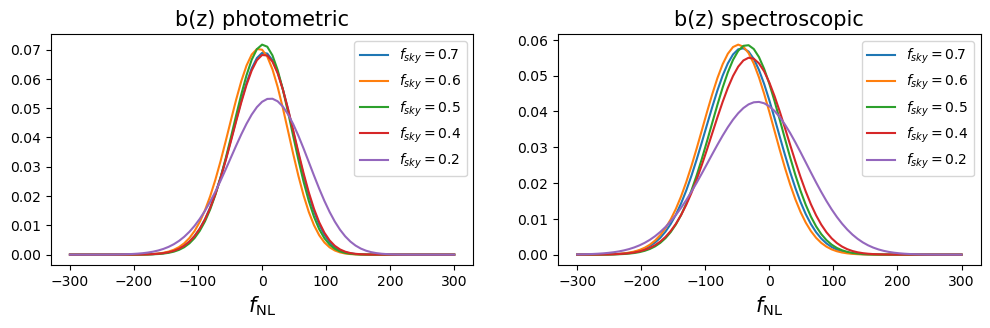

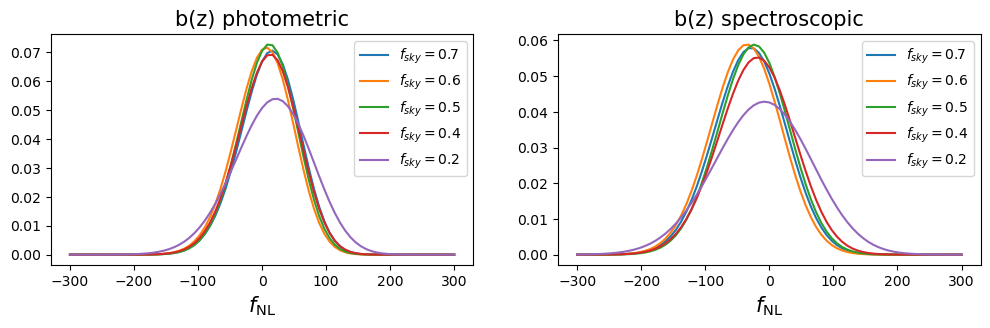

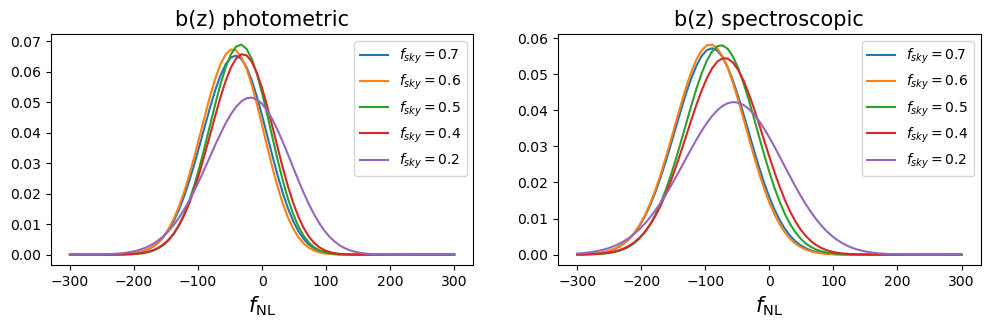

In [674]:
pl.figure(figsize=(12,3))
pl.subplot(121)
for fsky in kyoto.keys():
    pl.plot(results_baseline[fsky]['baseline']['sdss_photo']['posterior'][0],results_baseline[fsky]['baseline']['sdss_photo']['posterior'][1],label="$f_{sky}=%.1f$"%(float(fsky)/100))
pl.legend()
pl.xlabel('$f_{\\rm NL}$',size=15)
pl.title("b(z) photometric",size=15)
pl.subplot(122)
for fsky in kyoto.keys():
    pl.plot(results_baseline[fsky]['baseline']['sdss']['posterior'][0],results_baseline[fsky]['baseline']['sdss']['posterior'][1],label="$f_{sky}=%.1f$"%(float(fsky)/100))    
pl.xlabel('$f_{\\rm NL}$',size=15)  
pl.title("b(z) spectroscopic",size=15)
pl.legend()    



###### mag bias
pl.figure(figsize=(12,3))
pl.subplot(121)
for fsky in kyoto.keys():
    pl.plot(results_baseline[fsky]['magbias_dN']['sdss_photo']['posterior'][0],results_baseline[fsky]['magbias_dN']['sdss_photo']['posterior'][1],label="$f_{sky}=%.1f$"%(float(fsky)/100))
pl.legend()
pl.xlabel('$f_{\\rm NL}$',size=15)
pl.title("b(z) photometric",size=15)
pl.subplot(122)
for fsky in kyoto.keys():
    pl.plot(results_baseline[fsky]['magbias_dN']['sdss']['posterior'][0],results_baseline[fsky]['magbias_dN']['sdss']['posterior'][1],label="$f_{sky}=%.1f$"%(float(fsky)/100))    
pl.legend() 
pl.xlabel('$f_{\\rm NL}$',size=15)  
pl.title("b(z) spectroscopic",size=15)
pl.show()


###### mag bias
pl.figure(figsize=(12,3))
pl.subplot(121)
for fsky in kyoto.keys():
    pl.plot(results_baseline[fsky]['magbias_dNcum']['sdss_photo']['posterior'][0],results_baseline[fsky]['magbias_dNcum']['sdss_photo']['posterior'][1],label="$f_{sky}=%.1f$"%(float(fsky)/100))
pl.legend()
pl.xlabel('$f_{\\rm NL}$',size=15)
pl.title("b(z) photometric",size=15)
pl.subplot(122)
for fsky in kyoto.keys():
    pl.plot(results_baseline[fsky]['magbias_dNcum']['sdss']['posterior'][0],results_baseline[fsky]['magbias_dNcum']['sdss']['posterior'][1],label="$f_{sky}=%.1f$"%(float(fsky)/100))    
pl.legend() 
pl.xlabel('$f_{\\rm NL}$',size=15)  
pl.title("b(z) spectroscopic",size=15)
pl.show()
#pl.plot(results_baseline[50]['baseline']['sdss']['posterior'][0],results_baseline[50]['baseline']['sdss']['posterior'][1])
#print(results_baseline[50]['baseline']['sdss']['sigma'],results_baseline[50]['baseline']['sdss_photo']['2sigma']),

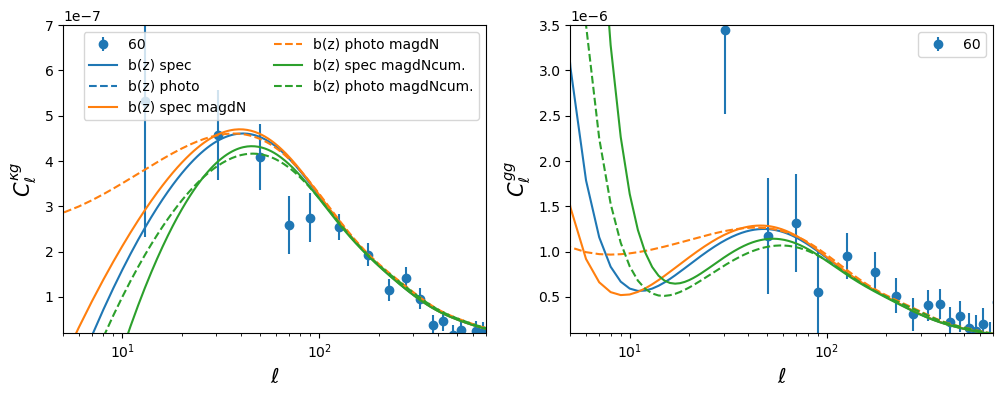

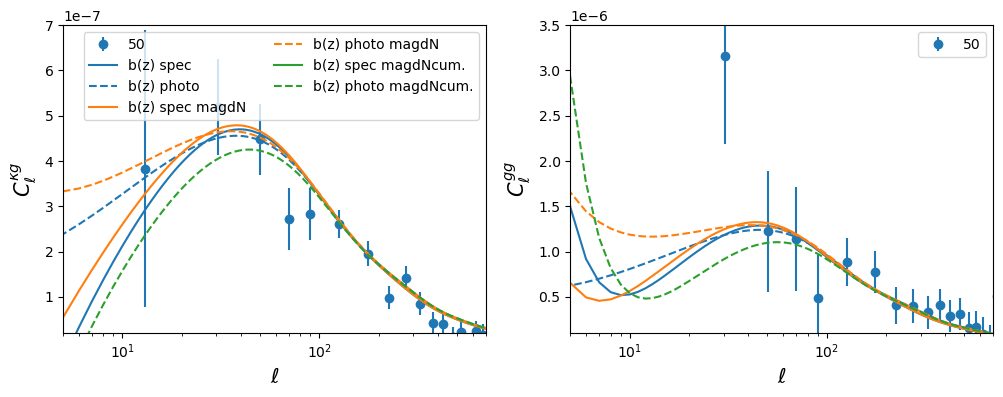

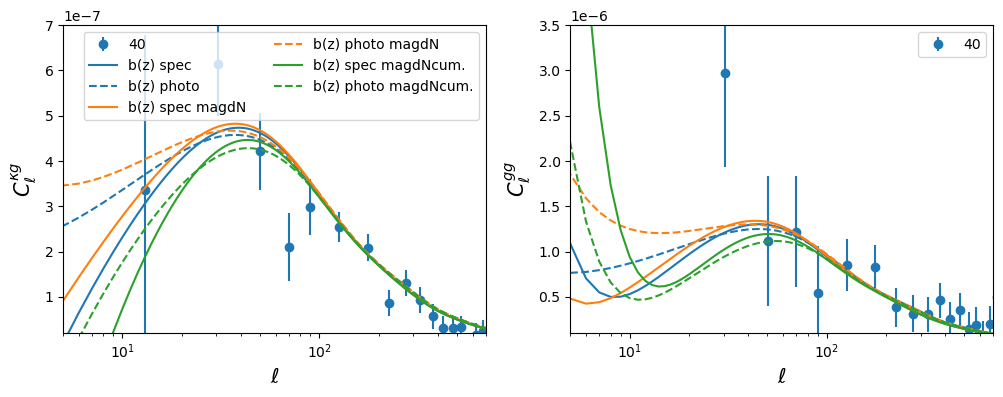

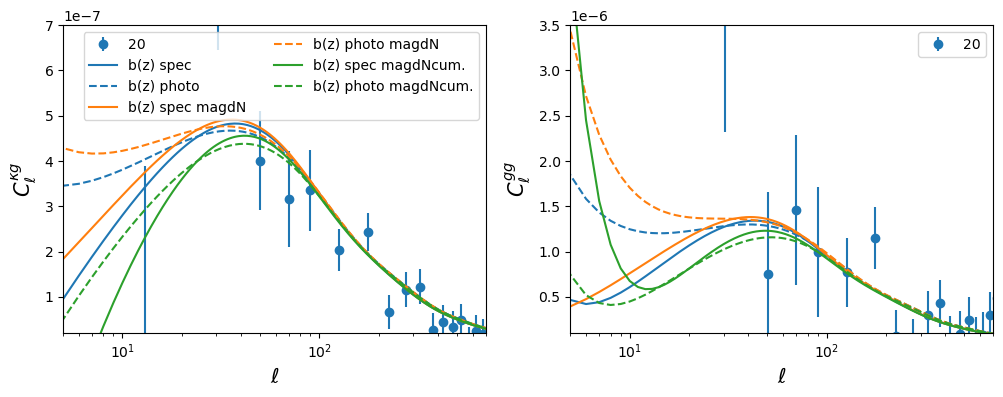

In [890]:

for fsky in [60,50,40,20]:#kyoto.keys():
    pl.figure(figsize=(12,4))
    #print(results_baseline[fsky]['baseline'].keys())
    th = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=results_baseline[fsky]['baseline']['sdss']['bestfit'][0],bz_model=bz_sdss)
    th_photo = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=results_baseline[fsky]['baseline']['sdss_photo']['bestfit'][0],bz_model=bz_sdss_photo)    
    th_magdN = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=results_baseline[fsky]['magbias_dN']['sdss']['bestfit'][0],bz_model=bz_sdss)
    th_photo_magdN = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=results_baseline[fsky]['magbias_dN']['sdss_photo']['bestfit'][0],bz_model=bz_sdss_photo)    
    th_magdNcum = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=results_baseline[fsky]['magbias_dNcum']['sdss']['bestfit'][0],bz_model=bz_sdss)
    th_photo_magdNcum = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=results_baseline[fsky]['magbias_dNcum']['sdss_photo']['bestfit'][0],bz_model=bz_sdss_photo)    
    
    pl.subplot(121)
    pl.errorbar(lb,kyoto[fsky]['G20']['clkg'][0],kyoto[fsky]['G20']['clkg'][1],marker='o',ls='',label=fsky)
    #pl.errorbar(lb+1,kyoto['G20.4']['clkg'][0],kyoto[fsky]['G20.4']['clkg'][1],marker='o',ls='',label='G20.4')
    pl.errorbar(th[0],th[1],color='C0',label='b(z) spec')
    pl.errorbar(th[0],th_photo[1],color='C0',ls='--',label='b(z) photo')
    pl.errorbar(th[0],th_magdN[1],color='C1',label='b(z) spec magdN')
    pl.errorbar(th[0],th_photo_magdN[1],color='C1',ls='--',label='b(z) photo magdN')    
    pl.errorbar(th[0],th_magdNcum[1],color='C2',label='b(z) spec magdNcum.')
    pl.errorbar(th[0],th_photo_magdNcum[1],color='C2',ls='--',label='b(z) photo magdNcum.')        
    #pl.xscale('log')
    #pl.yscale('log')
    #pl.ylim(0,1e-06)
    ##pl.xlim(10,700)
    pl.xscale('log')
    pl.ylim(2e-08,0.7e-06)
    pl.xlim(5,700)
    pl.legend(ncol=2,fontsize=10)
    pl.xlabel("$\ell$",size=15)
    pl.ylabel("$C^{\kappa g}_\ell$",size=15)        
    
    
    pl.subplot(122)
    pl.errorbar(lb,kyoto[fsky]['G20']['clgg'][0],kyoto[fsky]['G20']['clgg'][1],marker='o',ls='',label=fsky)
    #pl.errorbar(lb+3,kyoto[fsky]['G20.4']['clgg'][0],kyoto[fsky]['G20.4']['clgg'][1],marker='o',ls='')
    pl.errorbar(th[0],th[2],color='C0')
    pl.errorbar(th[0],th_photo[2],color='C0',ls='--')
    pl.errorbar(th[0],th_magdN[2],color='C1')
    pl.errorbar(th[0],th_photo_magdN[2],color='C1',ls='--')    
    pl.errorbar(th[0],th_magdNcum[2],color='C2')
    pl.errorbar(th[0],th_photo_magdNcum[2],color='C2',ls='--')        
    #pl.xscale('log')
    #pl.yscale('log')
    #pl.ylim(1e-07,1e-05)
    #pl.xlim(1,700)   
    pl.xscale('log')
    #pl.yscale('log')
    pl.xlabel("$\ell$",size=15)
    pl.ylabel("$C^{gg}_\ell$",size=15)
    pl.ylim(1e-07,3.5e-06)
    pl.xlim(5,700)    
     
    pl.legend(ncol=2,fontsize=10)
    
    pl.show()
    

# New catalog

In [59]:
results_baseline20 ={}
lmax_th = binning.lmax
for fsky in [50,0.5]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data(kyoto_new,'G20',fsky)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.,sample=False)
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.35,sample=False)
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.51,sample=False)
    #results_baseline20[fsky]={'baseline':results_nomag,'magbias_dNcum':results_0p52,'magbias_dN':results_0p37}
    print()
#with open("kyoto_fnl_posterior_20230406_20.pkl","wb") as f:
#    pkl.dump(results_baseline20,f)

lb 36 post cut data 35
50 sdss magmagbias 0.0 [-33.78855226] [[36.53838803]] 1.0547242319092538 0.3812342640365667
50 sdss_photo magbias 0.0 [-3.52135554] [[30.06725559]] 1.0864936253585382 0.3346086490666744
50 sdss magmagbias 0.35 [-20.97440475] [[36.44714762]] 1.0487008485612976 0.39040486533770924
50 sdss_photo magbias 0.35 [7.30930599] [[29.86235075]] 1.0781853381132842 0.3465048851070833
50 sdss magmagbias 0.51 [-62.43300802] [[36.70743086]] 1.093665207360381 0.3245187535467484
50 sdss_photo magbias 0.51 [-28.38775712] [[30.46368338]] 1.1255529154177961 0.28176364100832485

lb 36 post cut data 35
0.5 sdss magmagbias 0.0 [-5.29557486] [[35.56610504]] 0.981040499722845 0.49903754935251476
0.5 sdss_photo magbias 0.0 [24.58347026] [[28.6975281]] 0.983658313437018 0.4946873129581302
0.5 sdss magmagbias 0.35 [8.81065082] [[35.42261441]] 0.9709236460729294 0.5159191984399696
0.5 sdss_photo magbias 0.35 [36.01250733] [[28.40722661]] 0.9654492728773016 0.5250931149375713
0.5 sdss magmagbi

In [81]:
results_baseline205 ={}
for fsky in [50,0.5]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data(kyoto_new,'G20.5',fsky)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.,sample=False)
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.18,sample=False)
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.43,sample=False)
    #results_baseline205[fsky]={'baseline':results_nomag,'magbias_dNcum':results_0p52,'magbias_dN':results_0p37}
    print()
#with open("kyoto_fnl_posterior_20230406_205.pkl","wb") as f:
#    pkl.dump(results_baseline205,f)

lb 36 post cut data 35
50 sdss magmagbias 0.0 [-88.71558791] [[28.15233732]] 1.5554927099032583 0.020480786888667946
50 sdss_photo magbias 0.0 [-50.82190347] [[23.20640863]] 1.5242155581017003 0.025775145624169604
50 sdss magmagbias 0.18 [-33.38404931] [[27.6416265]] 1.4585698175445738 0.04102365769659366
50 sdss_photo magbias 0.18 [-6.08250955] [[22.22278211]] 1.4037009082009388 0.05932845527920705
50 sdss magmagbias 0.43 [-96.52675057] [[28.20235062]] 1.5890695432735287 0.01590789511668944
50 sdss_photo magbias 0.43 [-57.45837231] [[23.30998359]] 1.556639263761995 0.02030684235437219

lb 36 post cut data 35
0.5 sdss magmagbias 0.0 [-63.22919966] [[28.09469164]] 1.646954341141985 0.010151100097427701
0.5 sdss_photo magbias 0.0 [-24.56625857] [[22.59563136]] 1.5925847310956744 0.015487312599795633
0.5 sdss magmagbias 0.18 [-0.31381339] [[27.20902734]] 1.558760395807702 0.01998855763137264
0.5 sdss_photo magbias 0.18 [23.30270882] [[21.11472427]] 1.4402740576144435 0.046488249577127716


In [82]:
results_baseline20x ={}
for fsky in [50,0.5]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data_kg(kyoto_new,'G20',fsky)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.,sample=False,fit_type='cross')
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.35,sample=False,fit_type='cross')
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.51,sample=False,fit_type='cross')

50 sdss magmagbias 0.0 [-39.61831174] [[37.3579137]] 1.275532249400489 0.19717705458490342
50 sdss_photo magbias 0.0 [-12.31902211] [[31.50809226]] 1.3626193043694759 0.1439706446529846
50 sdss magmagbias 0.35 [-28.0860565] [[37.3579267]] 1.2448840675487254 0.21908271947708913
50 sdss_photo magbias 0.35 [-2.29996827] [[31.50808619]] 1.3408546045569583 0.1560601687491039
50 sdss magmagbias 0.51 [-64.98952415] [[37.3579083]] 1.3926803173264275 0.12852161561195086
50 sdss_photo magbias 0.51 [-34.36143018] [[31.50805302]] 1.4578122774019358 0.0996776765454781
0.5 sdss magmagbias 0.0 [-20.63795035] [[36.71897971]] 1.034793148338772 0.41503972303409875
0.5 sdss_photo magbias 0.0 [5.27044432] [[30.87364149]] 1.0824246196233034 0.3639625688472299
0.5 sdss magmagbias 0.35 [-7.99342558] [[36.71897433]] 0.9899812648792468 0.4659618692616472
0.5 sdss_photo magbias 0.35 [16.22380384] [[30.8736553]] 1.046572690411721 0.402092220902905
0.5 sdss magmagbias 0.51 [-48.4562786] [[36.71897325]] 1.19137364

In [83]:
results_baseline20highl ={}
for fsky in [50,0.5]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data(kyoto_new,'G20',fsky,lmin_gg=40)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.,sample=False)
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.35,sample=False)
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.51,sample=False)

lb 36 post cut data 34
50 sdss magmagbias 0.0 [-40.03712032] [[36.79597715]] 1.081098746710087 0.34363670359788556
50 sdss_photo magbias 0.0 [-12.27005381] [[30.66255685]] 1.1049597059980314 0.3107343683077377
50 sdss magmagbias 0.35 [-27.98378465] [[36.7800748]] 1.0769535278724631 0.34953476026992325
50 sdss_photo magbias 0.35 [-2.18455663] [[30.62145369]] 1.1021010417153132 0.31457934332656
50 sdss magmagbias 0.51 [-66.79889912] [[36.83009731]] 1.1196932056932363 0.29135114279377494
50 sdss_photo magbias 0.51 [-34.79251599] [[30.74981735]] 1.1365264160839998 0.2701171358661567
lb 36 post cut data 34
0.5 sdss magmagbias 0.0 [-13.91591662] [[36.0785306]] 0.9031400432192445 0.6270553816889717
0.5 sdss_photo magbias 0.0 [13.08494912] [[29.88168792]] 0.9117717656464744 0.6128325815935542
0.5 sdss magmagbias 0.35 [-0.58495246] [[36.05786685]] 0.894118850529111 0.6418329342491651
0.5 sdss_photo magbias 0.35 [24.25919195] [[29.83054764]] 0.8995148980739848 0.6330056112970611
0.5 sdss magmagb

In [84]:
results_baseline20a ={}
for fsky in [0.5]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data_gg(kyoto_new,'G20',fsky)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.,sample=False,fit_type='auto')
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.35,sample=False,fit_type='auto')
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.51,sample=False,fit_type='auto')

0.5 sdss magmagbias 0.0 [104.04764863] [[64.06633776]] 0.7364401244585467 0.7587749519259319
0.5 sdss_photo magbias 0.0 [95.35118361] [[41.52810551]] 0.6857880458224954 0.8111728330659317
0.5 sdss magmagbias 0.35 [117.13935637] [[62.25844218]] 0.7532209879478454 0.7404245609075629
0.5 sdss_photo magbias 0.35 [101.87379419] [[40.6376191]] 0.6962355512181685 0.8007769994150663
0.5 sdss magmagbias 0.51 [69.88104688] [[69.42299261]] 0.7149894361156034 0.7815580545546127
0.5 sdss_photo magbias 0.51 [78.29697541] [[44.0758694]] 0.6724027438258969 0.8241440890009522


In [86]:
results_baseline20lcuts ={}
for fsky in [50,0.5]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data(kyoto_new,'G20',fsky,lmin_gg=40,lmax_kg=520,lmax_gg=520)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.,sample=False)
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.35,sample=False)
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.51,sample=False)
    print()

lb 36 post cut data 24
50 sdss magmagbias 0.0 [-39.65567389] [[36.79842888]] 0.8510550261728701 0.6674377374286096
50 sdss_photo magbias 0.0 [-11.8907477] [[30.66454786]] 0.8678763527928193 0.6442539068635655
50 sdss magmagbias 0.35 [-27.63669594] [[36.78257022]] 0.85111367345051 0.6673574189932772
50 sdss_photo magbias 0.35 [-1.83717097] [[30.62357372]] 0.8721776564451232 0.6382844151095127
50 sdss magmagbias 0.51 [-66.33966525] [[36.83245775]] 0.8923980802778655 0.610060810171247
50 sdss_photo magbias 0.51 [-34.33971035] [[30.7516735]] 0.8940420652399107 0.6077573849059525

lb 36 post cut data 24
0.5 sdss magmagbias 0.0 [-13.53196958] [[36.08131042]] 0.691210448860555 0.8596070269017363
0.5 sdss_photo magbias 0.0 [13.48124013] [[29.88380746]] 0.6861631972274023 0.8644511023773344
0.5 sdss magmagbias 0.35 [-0.23946253] [[36.06059966]] 0.6836436655840934 0.8668348144755039
0.5 sdss_photo magbias 0.35 [24.61782871] [[29.83276482]] 0.6765986252366886 0.8733773231266786
0.5 sdss magmagbia

In [85]:
results_baseline20lowl ={}
for fsky in [50,0.5]:#kyoto.keys():
    datavec,datavec_err,cov,lbmask = prepare_data(kyoto_new,'G20',fsky,lmax_kg=520,lmax_gg=520)
    results_nomag = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.,sample=False)
    results_0p37 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.35,sample=False)
    results_0p52 = get_fnl_stats(lbmask,datavec,datavec_err,cov,dndz_err20,do_magnification=0.51,sample=False)
    print()

lb 36 post cut data 25
50 sdss magmagbias 0.0 [-32.45189409] [[36.53028324]] 0.9349219346265957 0.5531342365920904
50 sdss_photo magbias 0.0 [-1.64723859] [[30.03446417]] 0.9581036026640591 0.5201236005167711
50 sdss magmagbias 0.35 [-19.48597386] [[36.43645897]] 0.9332172219338631 0.5555715204472544
50 sdss_photo magbias 0.35 [9.37395281] [[29.82219844]] 0.9542864306672083 0.5255377028458252
50 sdss magmagbias 0.51 [-61.44895516] [[36.70451684]] 0.973266251042518 0.49873230297880466
50 sdss_photo magbias 0.51 [-27.00711159] [[30.44697355]] 0.9940358643963664 0.4698065220157185

lb 36 post cut data 25
0.5 sdss magmagbias 0.0 [-4.37952421] [[35.55910368]] 0.7582647718739358 0.7932815470587925
0.5 sdss_photo magbias 0.0 [25.70242443] [[28.67207568]] 0.747409804626174 0.806013537053124
0.5 sdss magmagbias 0.35 [9.73205868] [[35.41446214]] 0.746836472100072 0.8066758790914641
0.5 sdss_photo magbias 0.35 [37.13387177] [[28.3797548]] 0.7270443722841547 0.8288882296625423
0.5 sdss magmagbias 

# Old results and tests.

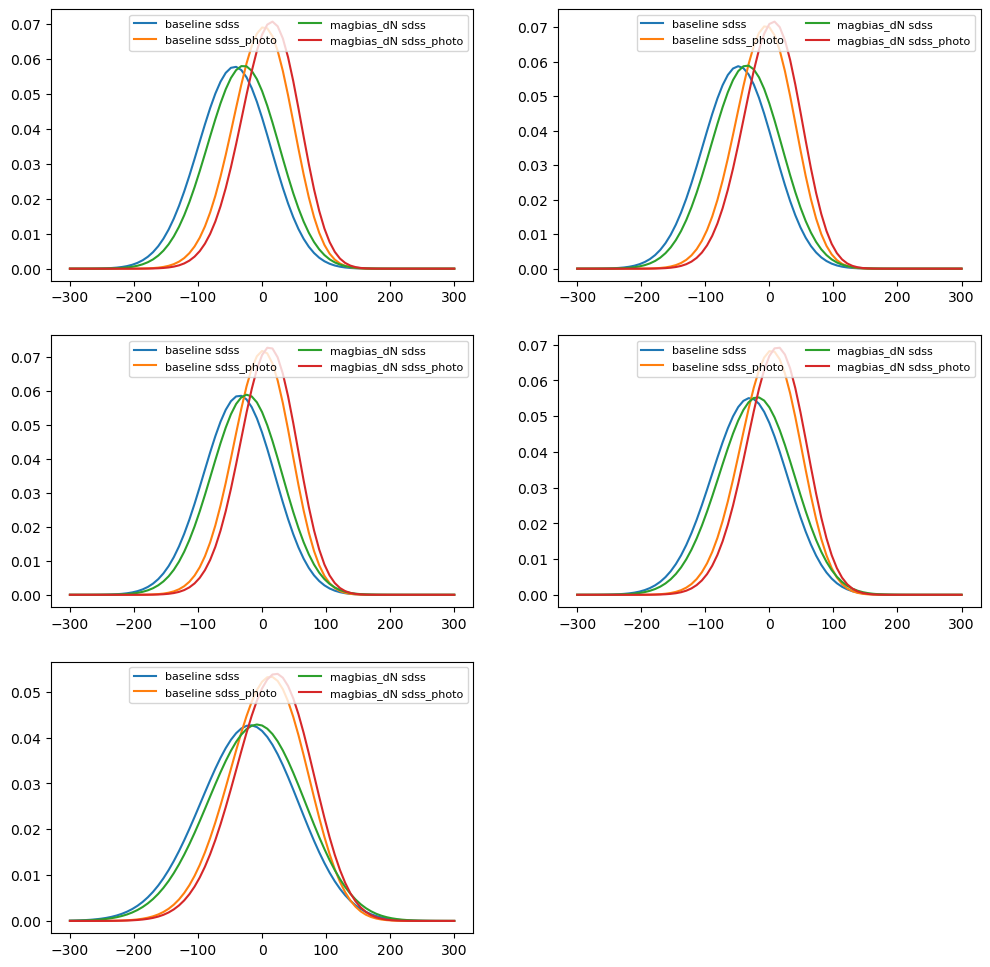

In [645]:
pl.figure(figsize=(12,12))
for i,fsky in enumerate(kyoto.keys()):
    fnum = 320+i+1
    pl.subplot(fnum)
    for k in results_baseline[fsky].keys():
        for bmodel in results_baseline[fsky][k].keys():
            if 'cum' in k: continue
            pl.plot(results_baseline[fsky][k][bmodel]['posterior'][0],results_baseline[fsky][k][bmodel]['posterior'][1],label='%s %s'%(k,bmodel))
    pl.legend(ncol=2,fontsize=8)
pl.show()


In [292]:
# this cells includes the first bin of kg but not on gg
res = (datavec -func_bz_sdss(lb,popt[0]))
res_photo = datavec -func_bz_sdss_photo(lb,popt_photo[0])
chi2 = res@np.linalg.inv(cov)@res
chi2_photo = res_photo@np.linalg.inv(cov)@res_photo

print(popt, np.sqrt(pcov),chi2/(ndim-pcov.shape[0]),1-stats.chi2.cdf(chi2,ndim-1))
print(popt_photo, np.sqrt(pcov_photo),chi2_photo/(ndim-pcov.shape[0]),1-stats.chi2.cdf(chi2_photo,ndim-1))

[-45.73169087] [[47.08982693]] 1.2129936533246963 0.18346997609845217
[-5.91007404] [[36.81560077]] 1.222951408248117 0.17407096652075238


In [296]:
def func_bz_sdss_photo_magnification(x, fNL):
    cls_th = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=fNL,bz_model=bz_sdss,
                          do_magnification=0.52)
    return np.append(binning.bin_cell(cls_th[1]),binning.bin_cell(cls_th[2]))[lbmask]

popt_photo_mag, pcov_photo_mag = optimize.curve_fit(func_bz_sdss_photo_magnification, lb, datavec,sigma=cov,p0=[0.],absolute_sigma=True)

# this cells includes the first bin of kg but not on gg
res_photo_mag = datavec -func_bz_sdss_photo_magnification(lb,popt_photo_mag[0])
chi2_photo_mag = res_photo_mag@np.linalg.inv(cov)@res_photo_mag

print(popt_photo_mag, np.sqrt(pcov_photo_mag),chi2_photo_mag/(ndim-pcov_photo_mag.shape[0]),1-stats.chi2.cdf(chi2_photo_mag,ndim-1))

[-97.15184557] [[47.75384346]] 1.3386815151658547 0.08964138336986838


In [ ]:
popt_photo, pcov_photo = optimize.curve_fit(func_bz_sdss_photo, lb, datavec,sigma=cov,p0=[0.],absolute_sigma=True)

In [280]:
fnl_post =[]
fnl_gridsearch = np.linspace(-300,300,75)
for fnl_grid in fnl_gridsearch:
    res_photo_grid = datavec -func_bz_sdss_photo(lb,fnl_grid)
    fnl_post.append(res_photo_grid@np.linalg.inv(cov)@res_photo_grid)
    


-110.20408163265306 -69.38775510204081 [-28.57142857] 4.081632653061234 44.897959183673464
[[38.32000947]] 36.734693877551024 38.77551020408163


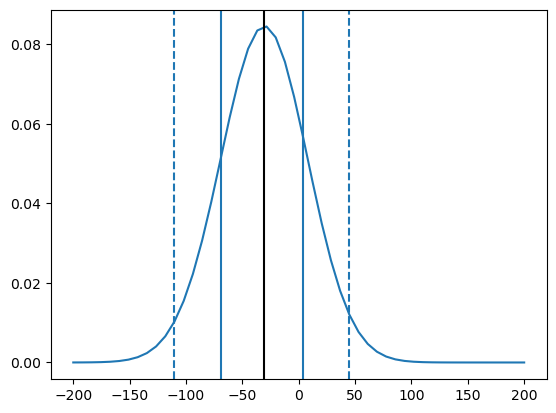

In [281]:
fnl_gridsearch = np.linspace(-200,200,50)
pdf = np.exp(-0.5*np.array(fnl_post))
pdf = pdf/np.trapz(pdf,fnl_gridsearch)
pdf = pdf *np.diff(fnl_gridsearch)[0]
cumpdf = np.cumsum(pdf)
lower_fnl = fnl_gridsearch[np.where(cumpdf>=0.16)[0]][0]
upper_fnl = fnl_gridsearch[np.where(cumpdf>=0.84)[0]][0]


lower_fnl_95 = fnl_gridsearch[np.where(cumpdf>=0.025)[0]][0]
upper_fnl_95 = fnl_gridsearch[np.where(cumpdf>=0.975)[0]][0]
print(lower_fnl_95,lower_fnl,fnl_gridsearch[pdf==pdf.max()],upper_fnl,upper_fnl_95)
print(np.sqrt(pcov_photo),0.5*(upper_fnl-lower_fnl),0.25*(upper_fnl_95-lower_fnl_95))
pl.plot(fnl_gridsearch,pdf)
pl.axvline(popt_photo[0],color='black')
pl.axvline(lower_fnl)
pl.axvline(upper_fnl)
pl.axvline(lower_fnl_95,ls='--')
pl.axvline(upper_fnl_95,ls='--')

In [200]:
# this cells includes the first bin of kg but not on gg
res = (datavec -func_bz_sdss(lb,popt[0]))
res_photo = datavec -func_bz_sdss_photo(lb,popt_photo[0])
chi2 = res@np.linalg.inv(cov)@res
chi2_photo = res_photo@np.linalg.inv(cov)@res_photo

print(popt, np.sqrt(pcov),chi2,1-stats.chi2.cdf(chi2,ndim-1))
print(popt_photo, np.sqrt(pcov_photo),chi2_photo,1-stats.chi2.cdf(chi2_photo,ndim-1))

[-44.30024808] [[47.06762771]] 24.48755855678658 0.3772359746131764
[-4.46506627] [[36.7632311]] 24.020174748520734 0.4026919740553867


In [104]:
def func_bz_sdss_photo_resc(x, fNL,bresc):
    cls_th = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=fNL,bz_model=bz_sdss_photo,
                           bg_model_rescaling=bresc)
    return np.append(binning.bin_cell(cls_th[1]),binning.bin_cell(cls_th[2]))[lbmask]

def func_bz_sdss_resc(x, fNL,bresc):
    cls_th = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=fNL,bz_model=bz_sdss,
                           bg_model_rescaling=bresc)
    return np.append(binning.bin_cell(cls_th[1]),binning.bin_cell(cls_th[2]))[lbmask]

def func_bz_const(x, fNL,b1):
    cls_th = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=fNL,bz_model=bz_constant,
                           bg_model_rescaling=b1)
    return np.append(binning.bin_cell(cls_th[1]),binning.bin_cell(cls_th[2]))[lbmask]





In [195]:
popt_photo_resc, pcov_photo_resc = optimize.curve_fit(func_bz_sdss_photo_resc, lb, datavec,sigma=cov,p0=[0.,1.],absolute_sigma=True)
popt_resc, pcov_resc = optimize.curve_fit(func_bz_sdss_resc, lb, datavec,sigma=cov,p0=[0.,1.],absolute_sigma=True)




In [105]:
popt_const, pcov_const,info,msg,ierr = optimize.curve_fit(func_bz_const, lb, datavec,sigma=cov,p0=[0.,2.],absolute_sigma=True,full_output=True)

In [197]:
def func_bz_eff(x, fNL):
    cls_th = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=fNL,bz_model=bz_constant,
                           bg_model_rescaling=popt_const[1])
    return np.append(binning.bin_cell(cls_th[1]),binning.bin_cell(cls_th[2]))[lbmask]

popt_eff, pcov_eff = optimize.curve_fit(func_bz_eff, lb, datavec,sigma=cov,p0=[0.],absolute_sigma=True,full_output=False)    



In [211]:
popt_eff,np.sqrt(pcov_eff)

(array([-109.13847341]), array([[76.25119453]]))

In [199]:
res_resc = (datavec -func_bz_sdss_resc(lb,popt_resc[0],popt_resc[1]))
res_photo_resc = datavec -func_bz_sdss_photo_resc(lb,popt_photo_resc[0],popt_photo_resc[1])
res_const = datavec -func_bz_const(lb,popt_const[0],popt_const[1])

chi2_resc = res_resc@np.linalg.inv(cov)@res_resc
chi2_photo_resc = res_photo_resc@np.linalg.inv(cov)@res_photo_resc
chi2_const = res_const@np.linalg.inv(cov)@res_const

print(popt_resc, np.sqrt(pcov_resc.diagonal()),chi2,1-stats.chi2.cdf(chi2_resc,ndim-2))
print(popt_photo_resc, np.sqrt(pcov_photo_resc.diagonal()),chi2_photo_resc,1-stats.chi2.cdf(chi2_photo_resc,ndim-2))
print(popt_const, np.sqrt(pcov_const.diagonal()),chi2,1-stats.chi2.cdf(chi2_const,ndim-2))
#print(popt_photo_resc,np.sqrt(pcov_photo_resc.diagonal()),pcov_photo_resc/np.sqrt(np.outer(pcov_photo_resc.diagonal(),pcov_photo_resc.diagonal())))
#print(popt_photo_resc,np.sqrt(pcov_resc.diagonal()),pcov_resc/np.sqrt(np.outer(pcov_resc.diagonal(),pcov_resc.diagonal())))

[-7.14517105  0.91457834] [6.80621308e+01 5.15284246e-02] 30.177785187590676 0.48057953074352566
[27.18340404  0.90415961] [5.72217617e+01 5.25181522e-02] 20.35719544484769 0.56070715093104
[-109.13839533    2.12264319] [88.17667645  0.11481326] 30.177785187590676 0.4226700393868559


In [203]:
# these numbers do not include the first 2 bins of gg

popt, pcov = optimize.curve_fit(func_bz_sdss, lb, datavec,sigma=cov,p0=[0.],absolute_sigma=True)
popt_photo, pcov_photo = optimize.curve_fit(func_bz_sdss_photo, lb, datavec,sigma=cov,p0=[0.],absolute_sigma=True)
res = (datavec -func_bz_sdss(lb,popt[0]))
res_photo = datavec -func_bz_sdss_photo(lb,popt_photo[0])
chi2 = res@np.linalg.inv(cov)@res
chi2_photo = res_photo@np.linalg.inv(cov)@res_photo

print(popt, np.sqrt(pcov),chi2,1-stats.chi2.cdf(chi2,ndim-1))
print(popt_photo, np.sqrt(pcov_photo),chi2_photo,1-stats.chi2.cdf(chi2_photo,ndim-1))

[-63.72729019] [[47.83871417]] 24.323043375798875 0.3861048563762439
[-29.30518504] [[38.31701138]] 23.601809245453456 0.42612399818229385


In [56]:

def func_bz_sdss_204(x, fNL):
    cls_th = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=fNL,bz_model=bz_sdss)
    return np.append(binning.bin_cell(cls_th[1]),binning.bin_cell(cls_th[2]))[lbmask]

def func_bz_sdss_photo_204(x, fNL):
    cls_th = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=fNL,bz_model=bz_sdss_photo)
    return np.append(binning.bin_cell(cls_th[1]),binning.bin_cell(cls_th[2]))[lbmask]


popt_204, pcov_204 = optimize.curve_fit(func_bz_sdss_204, lb, datavec_204,sigma=cov_204,p0=[0.],absolute_sigma=True)
popt_photo_204, pcov_photo_204 = optimize.curve_fit(func_bz_sdss_photo_204, lb, datavec_204,sigma=cov_204,p0=[0.],absolute_sigma=True)



In [157]:
def func_bz_const_204(x, fNL,b1):
    cls_th = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=fNL,bz_model=bz_constant,
                           bg_model_rescaling=b1)
    return np.append(binning.bin_cell(cls_th[1]),binning.bin_cell(cls_th[2]))[lbmask]

popt_const_204, pcov_const_204,info,msg,ierr = optimize.curve_fit(func_bz_const_204, lb, datavec_204,sigma=cov_204,p0=[0.,2.],absolute_sigma=True,full_output=True)

In [158]:
res_204 = (datavec_204 -func_bz_sdss_204(lb,popt_204[0]))
res_photo_204 = datavec_204 -func_bz_sdss_photo_204(lb,popt_photo_204[0])
res_const_204 = (datavec_204 -func_bz_const(lb,popt_const_204[0],popt_const_204[1]))

chi2_204 = res_204@np.linalg.inv(cov_204)@res_204
chi2_photo_204 = res_photo_204@np.linalg.inv(cov_204)@res_photo_204
chi2_const_204 = res_const_204@np.linalg.inv(cov_204)@res_const_204

print(popt_204, np.sqrt(pcov_204),chi2_204/(ndim-len(popt)),1-stats.chi2.cdf(chi2_204,ndim-1))
print(popt_photo_204, np.sqrt(pcov_photo_204),chi2_photo_204/(ndim-len(popt)),1-stats.chi2.cdf(chi2_photo_204,ndim-1))
print(popt_const_204, np.sqrt(pcov_const_204.diagonal()),chi2,1-stats.chi2.cdf(chi2_const_204,ndim-2))

[-57.65083318] [[37.98162661]] 2.148756175927155 0.0008898725118087203
[-17.94304353] [[28.56120396]] 2.1841400165852676 0.000689623726659927
[-118.61545305    2.21886807] [68.01242199  0.08909744] 30.177785187590676 0.002554841619721193


In [106]:
th = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=popt[0],bz_model=bz_sdss)
th_photo = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=popt_photo[0],bz_model=bz_sdss_photo)
th_const = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=popt_const[0]*0,bz_model=bz_constant,bg_model_rescaling=popt_const[1]*1)

th_204 = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=popt_204[0],bz_model=bz_sdss)
th_photo_204 = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=popt_photo_204[0],bz_model=bz_sdss_photo)
th_const_204 = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[2])],fNL_th=popt_const_204[0]*0,bz_model=bz_constant,bg_model_rescaling=popt_const_204[1])

NameError: name 'popt_204' is not defined

In [ ]:
th_const2= get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=0.*popt_const[0],bz_model=bz_constant,bg_model_rescaling=popt_const[1]*1)
th_const3 = get_theory_cl(b_h,[zint,np.interp(zint,dndz_err[0],dndz_err[1])],fNL_th=popt_const[0],bz_model=bz_constant,bg_model_rescaling=popt_const[1]*1)

pl.loglog(th_const2[0],th_const[1])
pl.loglog(th_const2[0],th_const2[1])
pl.loglog(th_const2[0],th_const3[1])

/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_26193/1408340384.py:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  pl.ylim(0,1e-06/1.8)


(1, 700)

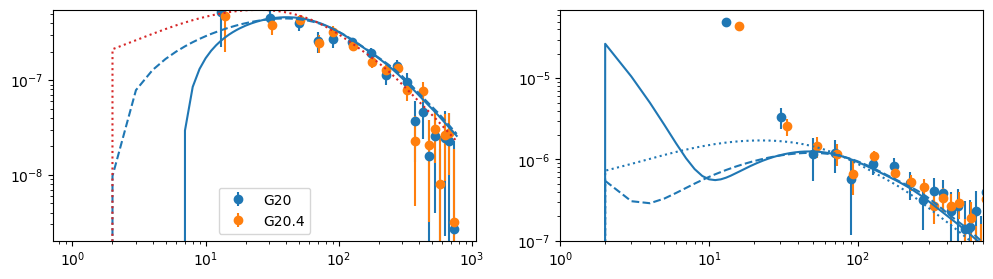

In [115]:
pl.figure(figsize=(12,3))
pl.subplot(121)
pl.errorbar(lb,data['G20']['clkg'][0],data['G20']['clkg'][1],marker='o',ls='',label='G20')
pl.errorbar(lb+1,data['G20.4']['clkg'][0],data['G20.4']['clkg'][1],marker='o',ls='',label='G20.4')
pl.errorbar(th[0],th[1],color='C0')
pl.errorbar(th[0],th_photo[1],color='C0',ls='--')
pl.errorbar(th[0],th_const[1],color='C3',ls=':')

#pl.errorbar(th[0],th_204[1],color='C1')
#pl.errorbar(th[0],th_photo_204[1],color='C1',ls='--')
pl.xscale('log')
pl.yscale('log')
pl.ylim(0,1e-06/1.8)
#pl.xlim(10,700)
pl.legend()

pl.subplot(122)
pl.errorbar(lb,data['G20']['clgg'][0],data['G20']['clgg'][1],marker='o',ls='')
pl.errorbar(lb+3,data['G20.4']['clgg'][0],data['G20.4']['clgg'][1],marker='o',ls='')
pl.errorbar(th[0],th[2],color='C0')
pl.errorbar(th[0],th_photo[2],color='C0',ls='--')
pl.errorbar(th[0],th_const[2],color='C0',ls=':')

#pl.errorbar(th[0],th_204[2],color='C1')
#pl.errorbar(th[0],th_photo_204[2],color='C1',ls='--')
#pl.errorbar(th[0],th_const_204[2],color='C3',ls=':')
pl.xscale('log')
pl.yscale('log')
pl.ylim(1e-07,3.5e-06*20)
pl.xlim(1,700)

In [116]:
cat[1].header

cat: [1].header: No such file or directory


In [117]:
def init_pars_test(lmin_limber=100,do_magnification_bias=False,do_cmb = True, do_transfer=True):

    pars = camb.CAMBparams()
    lmax=3*256-1 #1000
    
    pars.set_cosmology(H0=67.5, ombh2=0.02242, omch2=0.11933, mnu=0,tau=0.0561)
    As = np.e**3.047/1e10
    pars.InitPower.set_params(As=As, ns=0.9665)
    pars.set_for_lmax(lmax, lens_potential_accuracy=4)
    
    ##set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = False
    pars.Want_transfer = False
    pars.NonLinear = model.NonLinear_both
    
   
    pars.Accuracy.LensingBoost = 1.0
    pars.Accuracy.NonlinSourceBoost = 1.0
    pars.Accuracy.BesselBoost = 1.0

    pars.Accuracy.LimberBoost = 1.0
    pars.Accuracy.SourceLimberBoost = 2.0
    
    #density only is the default
    pars.SourceTerms.limber_windows = True
    pars.SourceTerms.limber_phi_lmin = lmin_limber    
    
    return pars 

In [130]:

pars = init_pars_test()
pars.SourceTerms.counts_lensing = False# do_magnification_bias  
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = False #weird problems at times
pars.SourceTerms.counts_radial   = False # negligible at l<10
pars.SourceTerms.counts_timedelay = False # negligible
pars.SourceTerms.counts_ISW = False #negligible
pars.SourceTerms.counts_velocity = False #negligible
pars.SourceTerms.counts_potential = False #negligible
pars.SourceTerms.counts_evolve = False # not sure what this is
#help(SplinedSourceWindow)
W = dndz_err[1]
pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(dndz_err[0]), z=dndz_err[0], 
                                                   W=W,source_type='counts',dlog10Ndm = 0.0)]
results = camb.get_results(pars)
cls_base = results.get_source_cls_dict(raw_cl=True)

In [131]:

pars = init_pars_test()
pars.SourceTerms.counts_lensing = False# do_magnification_bias  
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = False #weird problems at times
pars.SourceTerms.counts_radial   = True # negligible at l<10
pars.SourceTerms.counts_timedelay = False # negligible
pars.SourceTerms.counts_ISW = False #negligible
pars.SourceTerms.counts_velocity = False #negligible
pars.SourceTerms.counts_potential = False #negligible
pars.SourceTerms.counts_evolve = False # not sure what this is
#help(SplinedSourceWindow)
W = dndz_err[1]
pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(dndz_err[0]), z=dndz_err[0], 
                                                   W=W,source_type='counts',dlog10Ndm = 0.0)]
results = camb.get_results(pars)
cls_z = results.get_source_cls_dict(raw_cl=True)

In [132]:

pars = init_pars_test()
pars.SourceTerms.counts_lensing = False# do_magnification_bias  
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = False #weird problems at times
pars.SourceTerms.counts_radial   = True # negligible at l<10
pars.SourceTerms.counts_timedelay = False # negligible
pars.SourceTerms.counts_ISW = False #negligible
pars.SourceTerms.counts_velocity = False #negligible
pars.SourceTerms.counts_potential = False #negligible
pars.SourceTerms.counts_evolve = False # not sure what this is
#help(SplinedSourceWindow)
W = dndz_err[1]
pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(dndz_err[0]), z=dndz_err[0], 
                                                   W=W,source_type='counts',dlog10Ndm = 0.0)]
results = camb.get_results(pars)
cls_radial = results.get_source_cls_dict(raw_cl=True)

In [133]:

pars = init_pars_test()
pars.SourceTerms.counts_lensing = False# do_magnification_bias  
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = False #weird problems at times
pars.SourceTerms.counts_radial   = False # negligible at l<10
pars.SourceTerms.counts_timedelay = True # negligible
pars.SourceTerms.counts_ISW = False #negligible
pars.SourceTerms.counts_velocity = False #negligible
pars.SourceTerms.counts_potential = False #negligible
pars.SourceTerms.counts_evolve = False # not sure what this is
#help(SplinedSourceWindow)
W = dndz_err[1]
pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(dndz_err[0]), z=dndz_err[0], 
                                                   W=W,source_type='counts',dlog10Ndm = 0.0)]
results = camb.get_results(pars)
cls_time = results.get_source_cls_dict(raw_cl=True)

In [134]:

pars = init_pars_test()
pars.SourceTerms.counts_lensing = False# do_magnification_bias  
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = False #weird problems at times
pars.SourceTerms.counts_radial   = False # negligible at l<10
pars.SourceTerms.counts_timedelay = False # negligible
pars.SourceTerms.counts_ISW = False #negligible
pars.SourceTerms.counts_velocity = True #negligible
pars.SourceTerms.counts_potential = False #negligible
pars.SourceTerms.counts_evolve = False # not sure what this is
#help(SplinedSourceWindow)
W = dndz_err[1]
pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(dndz_err[0]), z=dndz_err[0], 
                                                   W=W,source_type='counts',dlog10Ndm = 0.0)]
results = camb.get_results(pars)
cls_vel = results.get_source_cls_dict(raw_cl=True)

In [135]:

pars = init_pars_test()
pars.SourceTerms.counts_lensing = False# do_magnification_bias  
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = False #weird problems at times
pars.SourceTerms.counts_radial   = False # negligible at l<10
pars.SourceTerms.counts_timedelay = False # negligible
pars.SourceTerms.counts_ISW = False #negligible
pars.SourceTerms.counts_velocity = False #negligible
pars.SourceTerms.counts_potential = True #negligible
pars.SourceTerms.counts_evolve = False # not sure what this is
#help(SplinedSourceWindow)
W = dndz_err[1]
pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(dndz_err[0]), z=dndz_err[0], 
                                                   W=W,source_type='counts',dlog10Ndm = 0.0)]
results = camb.get_results(pars)
cls_pot = results.get_source_cls_dict(raw_cl=True)

In [136]:

pars = init_pars_test()
pars.SourceTerms.counts_lensing = False# do_magnification_bias  
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = False #weird problems at times
pars.SourceTerms.counts_radial   = False # negligible at l<10
pars.SourceTerms.counts_timedelay = False # negligible
pars.SourceTerms.counts_ISW = False #negligible
pars.SourceTerms.counts_velocity = False #negligible
pars.SourceTerms.counts_potential = False #negligible
pars.SourceTerms.counts_evolve = True # not sure what this is
#help(SplinedSourceWindow)
W = dndz_err[1]
pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(dndz_err[0]), z=dndz_err[0], 
                                                   W=W,source_type='counts',dlog10Ndm = 0.0)]
results = camb.get_results(pars)
cls_ev = results.get_source_cls_dict(raw_cl=True)

In [170]:

pars = init_pars_test()
pars.SourceTerms.counts_lensing = False# do_magnification_bias  
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = False #weird problems at times
pars.SourceTerms.counts_radial   = False # negligible at l<10
pars.SourceTerms.counts_timedelay = False # negligible
pars.SourceTerms.counts_ISW = True #negligible
pars.SourceTerms.counts_velocity = False #negligible
pars.SourceTerms.counts_potential = False #negligible
pars.SourceTerms.counts_evolve = False # not sure what this is
#help(SplinedSourceWindow)
W = dndz_err[1]
pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(dndz_err[0]), z=dndz_err[0], 
                                                   W=W,source_type='counts',dlog10Ndm = 0.0043)]
results = camb.get_results(pars)
cls_isw = results.get_source_cls_dict(raw_cl=True)

In [267]:

pars = init_pars_test()
pars.SourceTerms.counts_lensing = True# do_magnification_bias  
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = False #weird problems at times
pars.SourceTerms.counts_radial   = False # negligible at l<10
pars.SourceTerms.counts_timedelay = False # negligible
pars.SourceTerms.counts_ISW = False #negligible
pars.SourceTerms.counts_velocity = False #negligible
pars.SourceTerms.counts_potential = False #negligible
pars.SourceTerms.counts_evolve = False # not sure what this is
#help(SplinedSourceWindow)
W = dndz_err[1]
pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(dndz_err[0]), z=dndz_err[0], 
                                                   W=W,source_type='counts',dlog10Ndm = 0.06)]
results = camb.get_results(pars)
cls_lens = results.get_source_cls_dict(raw_cl=True)
print(cls_lens['W1xW1'])

[0.00000000e+00 0.00000000e+00 2.12408133e-07 2.42503255e-07
 2.74128522e-07 3.06775239e-07 3.40216446e-07 3.73458931e-07
 4.05879938e-07 4.37394198e-07 4.67721364e-07 4.97092133e-07
 5.25219790e-07 5.52358173e-07 5.78295008e-07 6.03251761e-07
 6.27120409e-07 6.49960067e-07 6.71850215e-07 6.92750409e-07
 7.12648885e-07 7.31612684e-07 7.49705511e-07 7.66935455e-07
 7.83314930e-07 7.98876127e-07 8.13655631e-07 8.27683721e-07
 8.40980495e-07 8.53528796e-07 8.65327729e-07 8.76431731e-07
 8.86893692e-07 8.96732554e-07 9.05963038e-07 9.14604242e-07
 9.22676293e-07 9.30197355e-07 9.37183705e-07 9.43644581e-07
 9.49589418e-07 9.55030779e-07 9.59987126e-07 9.64477907e-07
 9.68522052e-07 9.72137895e-07 9.75342488e-07 9.78149848e-07
 9.80573213e-07 9.82625647e-07 9.84319970e-07 9.85668440e-07
 9.86681976e-07 9.87371079e-07 9.87746076e-07 9.87817082e-07
 9.87594335e-07 9.87089166e-07 9.86312737e-07 9.85275679e-07
 9.83988117e-07 9.82459995e-07 9.80701904e-07 9.78724108e-07
 9.76536269e-07 9.741474

In [268]:

pars = init_pars_test()
pars.SourceTerms.counts_lensing = True# do_magnification_bias  
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = True #weird problems at times
pars.SourceTerms.counts_radial   = True # negligible at l<10
pars.SourceTerms.counts_timedelay = True # negligible
pars.SourceTerms.counts_ISW = True #negligible
pars.SourceTerms.counts_velocity = True #negligible
pars.SourceTerms.counts_potential = True #negligible
pars.SourceTerms.counts_evolve = True # not sure what this is
#help(SplinedSourceWindow)
W = dndz_err[1]
pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(dndz_err[0]), z=dndz_err[0], 
                                                   W=W,source_type='counts',dlog10Ndm = 0.659)]
results = camb.get_results(pars)
cls_tot = results.get_source_cls_dict(raw_cl=True)




pars = init_pars_test()
pars.SourceTerms.counts_lensing = False# do_magnification_bias  
pars.SourceTerms.counts_density  = True
pars.SourceTerms.counts_redshift = True #weird problems at times
pars.SourceTerms.counts_radial   = True # negligible at l<10
pars.SourceTerms.counts_timedelay = True # negligible
pars.SourceTerms.counts_ISW = True #negligible
pars.SourceTerms.counts_velocity = True #negligible
pars.SourceTerms.counts_potential = True #negligible
pars.SourceTerms.counts_evolve = True # not sure what this is
#help(SplinedSourceWindow)
W = dndz_err[1]
pars.SourceWindows = [SplinedSourceWindow(bias_z=bz_sdss_photo(dndz_err[0]), z=dndz_err[0], 
                                                   W=W,source_type='counts',dlog10Ndm = 0.49)]
results = camb.get_results(pars)
cls_tot_nolens = results.get_source_cls_dict(raw_cl=True)

(1.5093647246096647e-08, 6.331496869050145e-07)

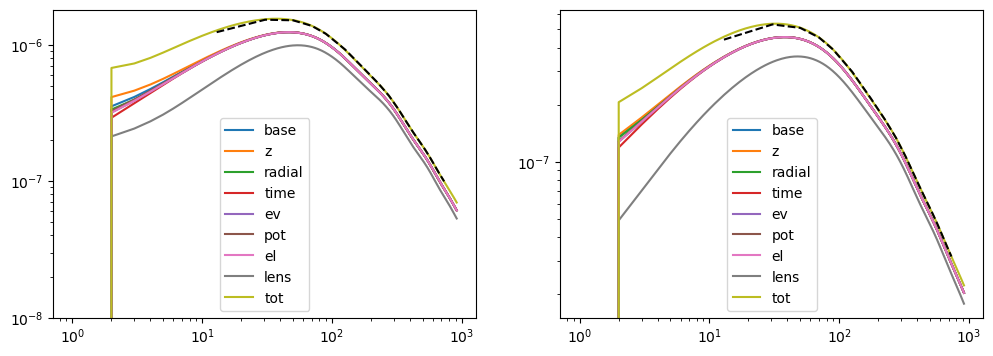

In [269]:
ell=np.arange(len(cls_base['W1xW1']))
p2k=ell*(ell+1)/2
options=['base','z','radial','time','ev','pot','el','lens','tot']
cls_list=[cls_base,cls_z,cls_radial,cls_time,cls_ev,cls_pot,cls_ev,cls_lens,cls_tot]
pl.figure(figsize=(12,4))
pl.subplot(121)
for cls_i,o in zip(cls_list,options):
    pl.loglog(ell,cls_i['W1xW1'],label=o)
pl.loglog(lb,binning.bin_cell(cls_tot['W1xW1'][:3*256]),color='black',ls='--')
#pl.loglog(lb,binning.bin_cell(cls_base['W1xW1'][:3*256]))
pl.loglog(ell,cls_tot_nolens['W1xW1'],color='black',ls='--')    
pl.legend()
#pl.xlim(2,100)
pl.ylim(1e-08,1.8e-06)
pl.ylim()
pl.subplot(122)
for cls_i,o in zip(cls_list,options):
    pl.loglog(ell,cls_i['W1xP']*p2k,label=o)
pl.loglog(lb,binning.bin_cell((cls_tot['W1xP']*p2k)[:3*256]),color='black',ls='--')
#pl.loglog(lb,binning.bin_cell(cls_base['W1xP'][:3*256]))
pl.loglog(ell,cls_tot_nolens['W1xP']*p2k,color='black',ls='--')    
pl.legend()
#pl.xlim(2,100)
#pl.ylim(2e-07,1.8e-06)
pl.ylim()
#pl.loglog(ell,cls_base['W1xW1'])
